In [115]:
import xarray
import paths
import numpy as np

ds = xarray.open_rasterio(paths.population_2020_aggregated()).astype(np.float64).rename({"x":"lon", "y":"lat"}).load()
ds = ds.where(ds>0)
world_pop = ds.sum(dim="lat").sum(dim="lon")
europe_pop = ds.where(ds.lat>35).where(ds.lat<65).where(ds.lon>-20).where(ds.lon<60).sum(dim="lat").sum(dim="lon")
e_na_pop = ds.where(ds.lat>25).where(ds.lat<55).where(ds.lon>-100).where(ds.lon<-60).sum(dim="lat").sum(dim="lon")
trop_s_amer_pop = ds.where(ds.lat>-25).where(ds.lat<10).where(ds.lon>-90).where(ds.lon<-55).sum(dim="lat").sum(dim="lon")
africa_pop = ds.where(ds.lat>-20).where(ds.lat<15).where(ds.lon>-10).where(ds.lon<45).sum(dim="lat").sum(dim="lon")
se_asia_pop = ds.where(ds.lat>20).where(ds.lat<50).where(ds.lon>95).where(ds.lon<130).sum(dim="lat").sum(dim="lon")

/tmp/ipykernel_134833/1384284731.py:5: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  ds = xarray.open_rasterio(paths.population_2020_aggregated()).astype(np.float64).rename({"x":"lon", "y":"lat"}).load()


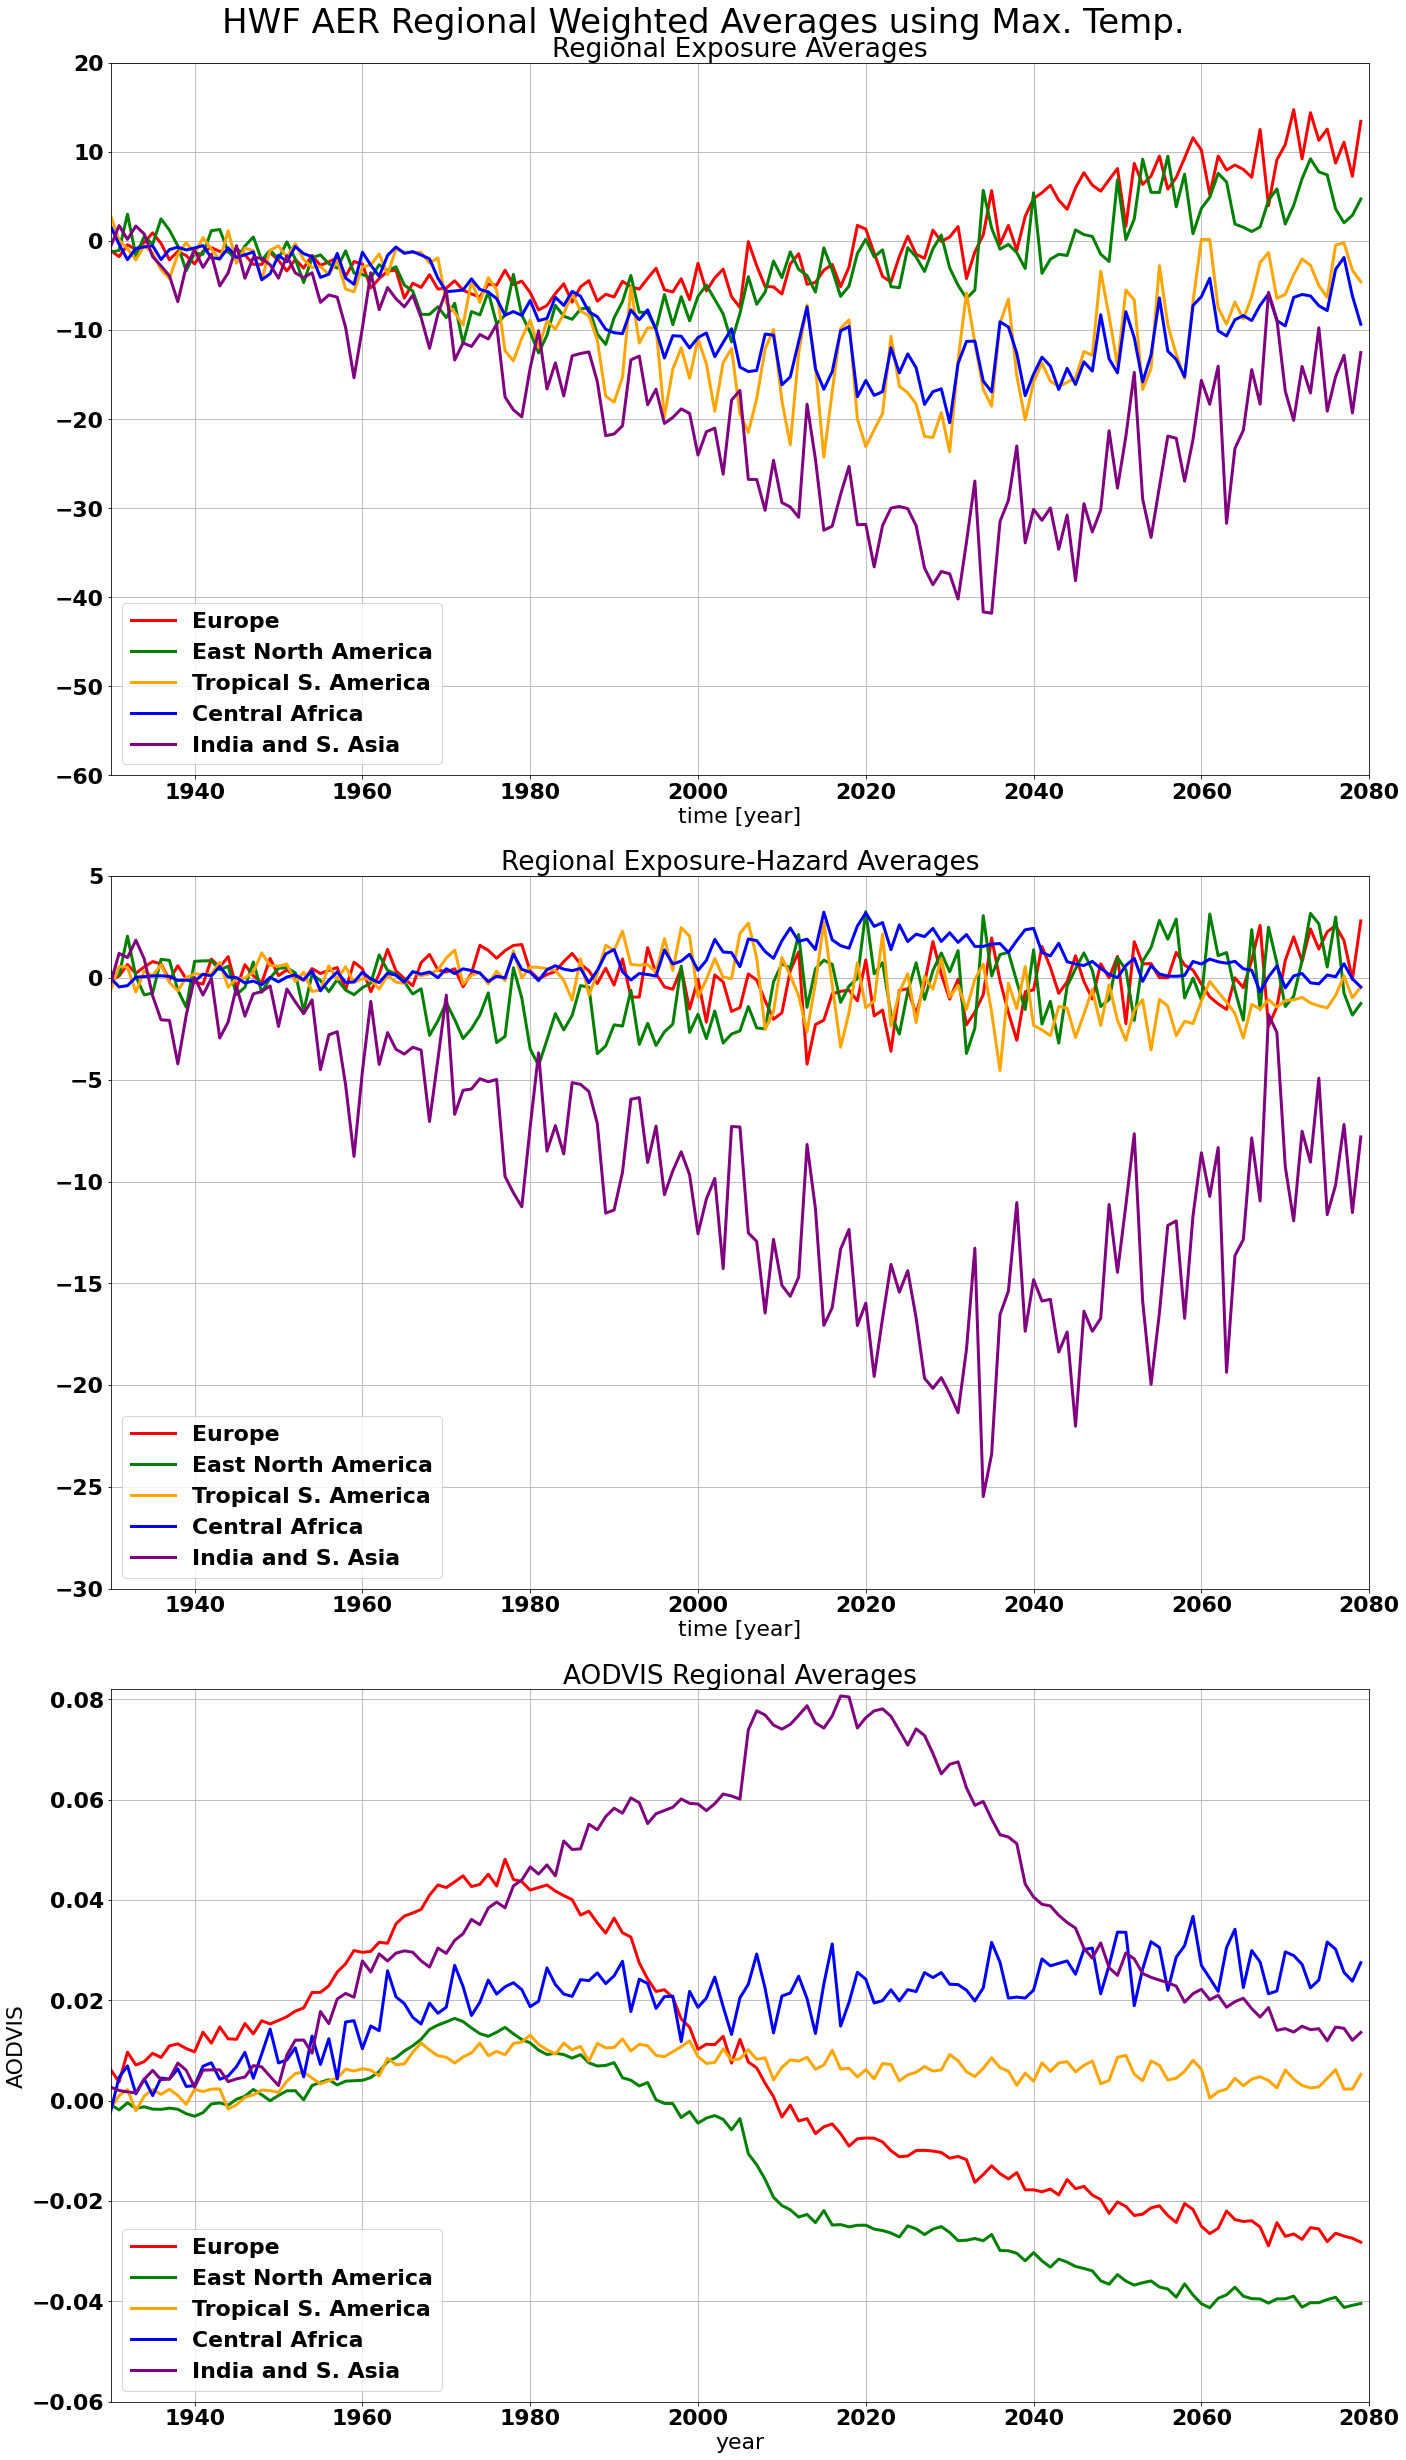

In [135]:
import xarray
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import colors
from matplotlib import rc
import matplotlib.patches as mpatches
import numpy as np
from matplotlib.offsetbox import AnchoredText
from paths import population_weighted_tmin_heat_outputs as ptmin, heat_out_trefht_tmin_members_1920_1950_CONTROL as tmin, land_mask
from paths import population_weighted_tmax_heat_outputs as ptmax, heat_out_trefht_tmax_members_1920_1950_CONTROL as tmax
from paths import land_mask, aod_vis_xaer_concatenated, aod_vis_all_concatenated

land_m = xarray.open_dataset(land_mask())["__xarray_dataarray_variable__"]
land_m = land_m.assign_coords(lon=(((land_m.lon + 180) % 360) - 180)).sortby('lon')

exp_num = "3136"
var = "HWF"

all_min, xghg_min, xaer_min = ptmax()
all_w_hwf = xarray.open_mfdataset([path for path in all_min if exp_num in path and var in path], concat_dim="member", combine="nested").days.sel(time=slice(1920, 2079)).mean(dim="member").load()
xaer_w_hwf = xarray.open_mfdataset([path for path in xaer_min if exp_num in path and var in path], concat_dim="member", combine="nested").days.sel(time=slice(1920, 2079)).mean(dim="member").load()

ds = (all_w_hwf - xaer_w_hwf)
ds = ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180)).sortby('lon')
ds = ds.where(land_m > 0)
europep = ds.where(ds.lat>35).where(ds.lat<65).where(ds.lon>-20).where(ds.lon<60).sum(dim="lat").sum(dim="lon") / europe_pop.sel(band=1).drop_vars("band")
e_nap = ds.where(ds.lat>25).where(ds.lat<55).where(ds.lon>-100).where(ds.lon<-60).sum(dim="lat").sum(dim="lon") / e_na_pop.sel(band=1).drop_vars("band")
trop_s_amerp = ds.where(ds.lat>-25).where(ds.lat<10).where(ds.lon>-90).where(ds.lon<-55).sum(dim="lat").sum(dim="lon") / trop_s_amer_pop.sel(band=1).drop_vars("band")
africap = ds.where(ds.lat>-20).where(ds.lat<15).where(ds.lon>-10).where(ds.lon<45).sum(dim="lat").sum(dim="lon") / africa_pop.sel(band=1).drop_vars("band")
se_asiap = ds.where(ds.lat>5).where(ds.lat<40).where(ds.lon>65).where(ds.lon<120).sum(dim="lat").sum(dim="lon") / se_asia_pop.sel(band=1).drop_vars("band")

all_min, xghg_min, xaer_min = tmax()
all_uw_hwf = xarray.open_mfdataset([path for path in all_min if exp_num in path], concat_dim="member", combine="nested")["HWF_tx90"].dt.days.sel(time=slice(1920, 2079)).mean(dim="member").load()
xaer_uw_hwf = xarray.open_mfdataset([path for path in xaer_min if exp_num in path], concat_dim="member", combine="nested")["HWF_tx90"].dt.days.sel(time=slice(1920, 2079)).mean(dim="member").load()

ds = (all_uw_hwf - xaer_uw_hwf)
ds = ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180)).sortby('lon')
ds = ds.where(land_m > 0)
europe = ds.where(ds.lat>35).where(ds.lat<65).where(ds.lon>-20).where(ds.lon<60).mean(dim="lat").mean(dim="lon")
e_na  = ds.where(ds.lat>25).where(ds.lat<55).where(ds.lon>-100).where(ds.lon<-60).mean(dim="lat").mean(dim="lon")
trop_s_amer  = ds.where(ds.lat>-25).where(ds.lat<10).where(ds.lon>-90).where(ds.lon<-55).mean(dim="lat").mean(dim="lon")
africa  = ds.where(ds.lat>-20).where(ds.lat<15).where(ds.lon>-10).where(ds.lon<45).mean(dim="lat").mean(dim="lon")
se_asia  = ds.where(ds.lat>5).where(ds.lat<40).where(ds.lon>65).where(ds.lon<120).mean(dim="lat").mean(dim="lon")

plt.rcParams['axes.autolimit_mode'] = 'round_numbers'
rc('font', **{'family': 'normal', 'weight': 'bold', 'size': 22})
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 35), facecolor='w')
f.suptitle(f"{var} AER Regional Weighted Averages using Max. Temp.", fontsize=34)

trops_c = "orange"
na_c = "green"
africa_c = "blue"
seasia_c = "purple"
europe_c = "red"
ls = "-"
lw = 3
reg_w = 10

europep.plot(ax=ax1, linestyle=ls, linewidth=lw, color=europe_c, label="Europe")
e_nap.plot(ax=ax1, linestyle=ls, linewidth=lw, color=na_c, label="East North America")
trop_s_amerp.plot(ax=ax1, linestyle=ls, linewidth=lw, color=trops_c, label="Tropical S. America")
africap.plot(ax=ax1, linestyle=ls, linewidth=lw, color=africa_c, label="Central Africa")
se_asiap.plot(ax=ax1, linestyle=ls, linewidth=lw, color=seasia_c, label="India and S. Asia")


(europep - europe).plot(ax=ax2, linestyle=ls, linewidth=lw, color=europe_c, label="Europe")
(e_nap - e_na).plot(ax=ax2, linestyle=ls, linewidth=lw, color=na_c, label="East North America")
(trop_s_amerp - trop_s_amer).plot(ax=ax2, linestyle=ls, linewidth=lw, color=trops_c, label="Tropical S. America")
(africap - africa).plot(ax=ax2, linestyle=ls, linewidth=lw, color=africa_c, label="Central Africa")
(se_asiap - se_asia).plot(ax=ax2, linestyle=ls, linewidth=lw, color=seasia_c, label="India and S. Asia")


land_m = xarray.open_dataset("../data/land_mask.nc")["__xarray_dataarray_variable__"].load()
aod_data = aod_ds.sel(year=slice(1930, 2079))

ds = aod_data.mean(dim="member").load()
land_m = xarray.open_dataset(land_mask())["__xarray_dataarray_variable__"].load()
land_m = land_m.assign_coords(lon=(((ds.lon + 180) % 360) - 180)).sortby('lon')
ds = ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180)).sortby('lon')
ds = ds.where(land_m > 0)
europe = ds.where(ds.lat>35).where(ds.lat<65).where(ds.lon>-20).where(ds.lon<60).mean(dim="lat").mean(dim="lon")
e_na = ds.where(ds.lat>25).where(ds.lat<55).where(ds.lon>-100).where(ds.lon<-60).mean(dim="lat").mean(dim="lon")
trop_s_amer = ds.where(ds.lat>-25).where(ds.lat<10).where(ds.lon>-90).where(ds.lon<-55).mean(dim="lat").mean(dim="lon")
africa = ds.where(ds.lat>-20).where(ds.lat<15).where(ds.lon>-10).where(ds.lon<45).mean(dim="lat").mean(dim="lon")
se_asia = ds.where(ds.lat>20).where(ds.lat<50).where(ds.lon>95).where(ds.lon<130).mean(dim="lat").mean(dim="lon")

# ls = "-"
# lw = 3
# alpha = 0.7
# ax11 = ax1.twinx()

europe.plot(ax=ax3, linestyle=ls, linewidth=lw, color=europe_c, label="Europe")
e_na.plot(ax=ax3, linestyle=ls, linewidth=lw, color=na_c, label="East North America")
trop_s_amer.plot(ax=ax3, linestyle=ls, linewidth=lw, color=trops_c, label="Tropical S. America")
africa.plot(ax=ax3, linestyle=ls, linewidth=lw, color=africa_c, label="Central Africa")
se_asia.plot(ax=ax3, linestyle=ls, linewidth=lw, color=seasia_c, label="India and S. Asia")


ax1.set_xlim(1930, 2080)
ax1.set_ylim(-60, 20)
ax1.legend()
ax1.grid()

ax2.set_xlim(1930, 2080)
ax2.legend()
ax2.grid()

ax3.set_xlim(1930, 2080)
ax3.set_ylim(-0.06, 0.082)
ax3.legend(loc="lower left")
ax3.grid()

ax1.set_title("Regional Exposure Averages")
ax2.set_title("Regional Exposure-Hazard Averages")
ax3.set_title("AODVIS Regional Averages")

f.tight_layout()

/tmp/ipykernel_218987/639148775.py:11: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  ds = xarray.open_rasterio(population_2020_aggregated()).astype(np.float64).rename({"x":"lon", "y":"lat"}).load()


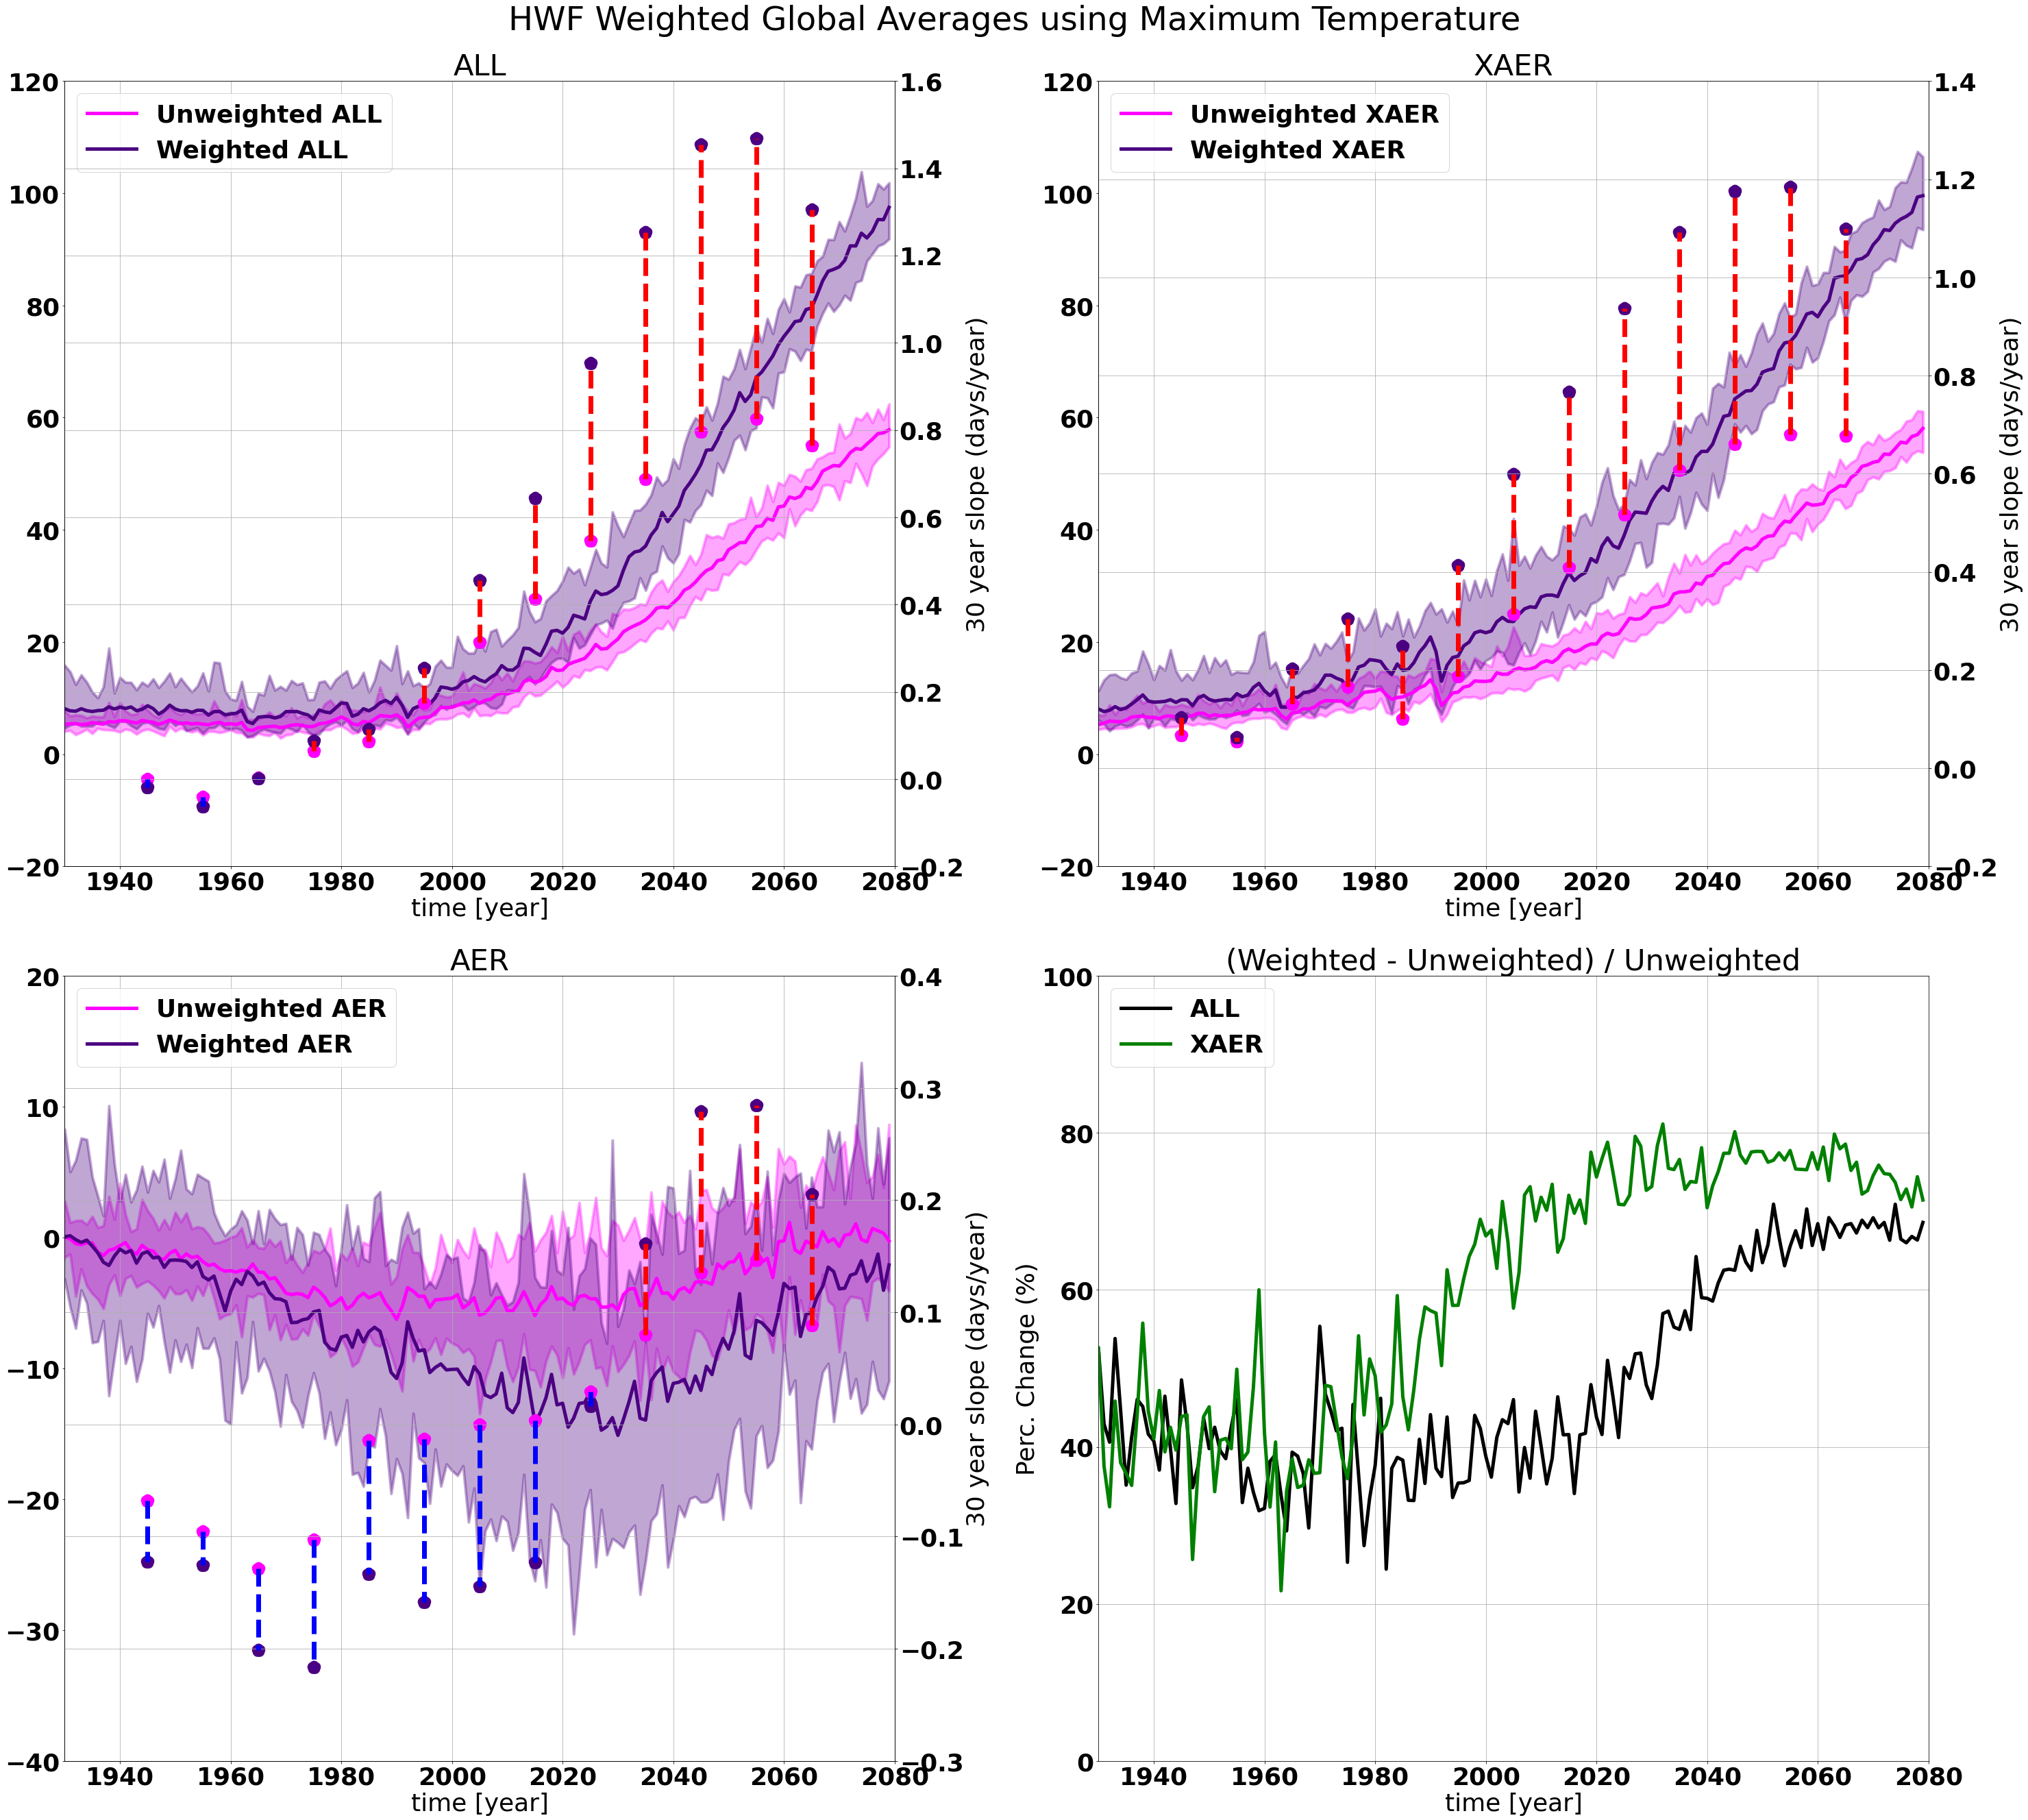

In [6]:
from paths import heat_out_trefht_tmin_members_1920_1950_CONTROL as tmin, heat_out_trefht_tmax_members_1920_1950_CONTROL as tmax, land_mask
from paths import population_weighted_tmin_heat_outputs as ptmin, population_2020_aggregated
import xarray
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import colors
from matplotlib import rc
from regionmask.defined_regions import ar6
import numpy as np

ds = xarray.open_rasterio(population_2020_aggregated()).astype(np.float64).rename({"x":"lon", "y":"lat"}).load()
ds = ds.where(ds>0)
world_pop = ds.sum(dim="lat").sum(dim="lon")
europe_pop = ds.where(ds.lat>35).where(ds.lat<65).where(ds.lon>-20).where(ds.lon<60).sum(dim="lat").sum(dim="lon")
e_na_pop = ds.where(ds.lat>25).where(ds.lat<55).where(ds.lon>-100).where(ds.lon<-60).sum(dim="lat").sum(dim="lon")
trop_s_amer_pop = ds.where(ds.lat>-25).where(ds.lat<10).where(ds.lon>-90).where(ds.lon<-55).sum(dim="lat").sum(dim="lon")
africa_pop = ds.where(ds.lat>-20).where(ds.lat<15).where(ds.lon>-10).where(ds.lon<45).sum(dim="lat").sum(dim="lon")
se_asia_pop = ds.where(ds.lat>20).where(ds.lat<50).where(ds.lon>95).where(ds.lon<130).sum(dim="lat").sum(dim="lon")


def poly_fit(ds):
    coeff = ds.mean(dim="member").polyfit(dim="time", deg=1)["polyfit_coefficients"].values
    print(f"{txt} -> {coeff}")
    return ds.time.values*coeff[0] + coeff[1]


def poly_fit_c(ds):
    coeff = ds.mean(dim="member").polyfit(dim="time", deg=1)["polyfit_coefficients"].values
    return coeff

mean_lw = 5
mean_bls = "-"
span_a = 0.3
bls_a = 0.35
reg_pt = 14.0
all_c = "black"
xaer_c = "green"
w_c = "indigo"
uw_c = "fuchsia"
bls_lw = 4

def decadal_regressions(ds):
    # (Slope, x_init, x_final)
    #decades = [1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020, 2030, 2040, 2050]
    decades = [1945, 1955, 1965, 1975, 1985, 1995, 2005, 2015, 2025, 2035, 2045, 2055, 2065]
    regs = [poly_fit_c(ds.sel(time=slice(1930, 1960)))[0],
            poly_fit_c(ds.sel(time=slice(1940, 1970)))[0],
            poly_fit_c(ds.sel(time=slice(1950, 1980)))[0],
            poly_fit_c(ds.sel(time=slice(1960, 1990)))[0],
            poly_fit_c(ds.sel(time=slice(1970, 2000)))[0],
            poly_fit_c(ds.sel(time=slice(1980, 2010)))[0],
            poly_fit_c(ds.sel(time=slice(1990, 2020)))[0],
            poly_fit_c(ds.sel(time=slice(2000, 2030)))[0],
            poly_fit_c(ds.sel(time=slice(2010, 2040)))[0],
            poly_fit_c(ds.sel(time=slice(2020, 2050)))[0],
            poly_fit_c(ds.sel(time=slice(2030, 2060)))[0],
            poly_fit_c(ds.sel(time=slice(2040, 2070)))[0],
            poly_fit_c(ds.sel(time=slice(2050, 2079)))[0]]
    
    return decades, regs


def plot_regs(ax, all_regs, xaer_regs, decades, a_c=all_c, b_c=xaer_c):
    ax.scatter(decades, all_regs, color=a_c, marker="*", linewidths=reg_pt)
    ax.scatter(decades, xaer_regs, color=b_c, marker="*", linewidths=reg_pt)
    for index, year in enumerate(decades):
        if all_regs[index] < xaer_regs[index]:
            ax.plot([year, year], [all_regs[index], xaer_regs[index]], color="red", linewidth=reg_pt/2, linestyle="--")
        else:
            ax.plot([year, year], [all_regs[index], xaer_regs[index]], color="blue", linewidth=reg_pt/2, linestyle="--")

    
exp_num = "3136"
var = "HWF"

#Mask for land
landmask = xarray.open_dataset(land_mask())["__xarray_dataarray_variable__"].load()

all_min, xghg_min, xaer_min = tmax()

all_un_hwf = xarray.open_mfdataset([path for path in all_min if exp_num in path], concat_dim="member", combine="nested")[f"{var}_tx90"].dt.days.sel(time=slice(1920, 2079)).where(landmask>0).mean(dim="lat").mean(dim="lon").load()
xaer_un_hwf = xarray.open_mfdataset([path for path in xaer_min if exp_num in path], concat_dim="member", combine="nested")[f"{var}_tx90"].dt.days.sel(time=slice(1920, 2079)).where(landmask>0).mean(dim="lat").mean(dim="lon").load()

all_min, xghg_min, xaer_min = ptmax()
all_w_hwf = xarray.open_mfdataset([path for path in all_min if exp_num in path and var in path], concat_dim="member", combine="nested").days.sel(time=slice(1920, 2079)).sum(dim="lat").sum(dim="lon").load()
xaer_w_hwf = xarray.open_mfdataset([path for path in xaer_min if exp_num in path and var in path], concat_dim="member", combine="nested").days.sel(time=slice(1920, 2079)).sum(dim="lat").sum(dim="lon").load()

all_w_hwf = all_w_hwf / world_pop.sel(band=1).drop_vars("band")
xaer_w_hwf = xaer_w_hwf / world_pop.sel(band=1).drop_vars("band")

decades, all_uw_hwf_r = decadal_regressions(all_un_hwf)
decades, all_w_hwf_r = decadal_regressions(all_w_hwf)

decades, xaer_uw_hwf_r = decadal_regressions(xaer_un_hwf)
decades, xaer_w_hwf_r = decadal_regressions(xaer_w_hwf)

aer_un_hwf = all_un_hwf - xaer_un_hwf
aer_w_hwf = all_w_hwf - xaer_w_hwf

decades, aer_uw_hwf_r = decadal_regressions(aer_un_hwf)
decades, aer_w_hwf_r = decadal_regressions(aer_w_hwf)

aer_un_hwf = all_un_hwf - xaer_un_hwf
aer_w_hwf = all_w_hwf - xaer_w_hwf

rc('font', **{'family': 'normal', 'weight': 'bold', 'size': 36})
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(42, 38), facecolor='w')
f.suptitle(f"{var} Weighted Global Averages using Maximum Temperature", fontsize=48)
plt.rcParams['axes.autolimit_mode'] = 'round_numbers'

all_un_hwf.mean(dim="member").plot(ax=ax1, linewidth=mean_lw, color=uw_c, label="Unweighted ALL")
all_w_hwf.mean(dim="member").plot(ax=ax1, linewidth=mean_lw, color=w_c, label="Weighted ALL")
ax1.fill_between(all_un_hwf.time, all_un_hwf.min(dim="member"), all_un_hwf.max(dim="member"), color=uw_c, linestyle=mean_bls, linewidth=bls_lw, alpha=bls_a)
ax1.fill_between(all_w_hwf.time, all_w_hwf.min(dim="member"), all_w_hwf.max(dim="member"), color=w_c, linestyle=mean_bls, linewidth=bls_lw, alpha=bls_a)
ax11 = ax1.twinx()
plot_regs(ax11, all_uw_hwf_r, all_w_hwf_r, decades, a_c=uw_c, b_c=w_c)
ax11.grid()
ax1.grid(axis="x")
ax1.legend(loc='upper left')
ax11.set_ylabel('30 year slope (days/year)')
ax11.set_title("ALL")

xaer_un_hwf.mean(dim="member").plot(ax=ax2, linewidth=mean_lw, color=uw_c, label="Unweighted XAER")
xaer_w_hwf.mean(dim="member").plot(ax=ax2, linewidth=mean_lw, color=w_c, label="Weighted XAER")
ax2.fill_between(xaer_un_hwf.time, xaer_un_hwf.min(dim="member"), xaer_un_hwf.max(dim="member"), color=uw_c, linestyle=mean_bls, linewidth=bls_lw, alpha=bls_a)
ax2.fill_between(xaer_w_hwf.time, xaer_w_hwf.min(dim="member"), xaer_w_hwf.max(dim="member"), color=w_c, linestyle=mean_bls, linewidth=bls_lw, alpha=bls_a)
ax22 = ax2.twinx()
plot_regs(ax22, xaer_uw_hwf_r, xaer_w_hwf_r, decades, a_c=uw_c, b_c=w_c)
ax22.grid()
ax2.grid(axis="x")
ax2.legend(loc='upper left')
ax22.set_ylabel('30 year slope (days/year)')
ax22.set_title("XAER")

aer_un_hwf.mean(dim="member").plot(ax=ax3, linewidth=mean_lw, color=uw_c, label="Unweighted AER")
aer_w_hwf.mean(dim="member").plot(ax=ax3, linewidth=mean_lw, color=w_c, label="Weighted AER")
ax3.fill_between(aer_un_hwf.time, aer_un_hwf.min(dim="member"), aer_un_hwf.max(dim="member"), color=uw_c, linestyle=mean_bls, linewidth=bls_lw, alpha=bls_a)
ax3.fill_between(aer_w_hwf.time, aer_w_hwf.min(dim="member"), aer_w_hwf.max(dim="member"), color=w_c, linestyle=mean_bls, linewidth=bls_lw, alpha=bls_a)
ax33 = ax3.twinx()
ax3.grid(axis="x")
plot_regs(ax33, aer_uw_hwf_r, aer_w_hwf_r, decades, a_c=uw_c, b_c=w_c)
ax33.grid()
ax3.legend(loc='upper left')
ax33.set_ylabel('30 year slope (days/year)')
ax33.set_title("AER")

all_ratio = (all_w_hwf.mean(dim="member") / all_un_hwf.mean(dim="member") - 1) * 100
xaer_ratio = (xaer_w_hwf.mean(dim="member") / xaer_un_hwf.mean(dim="member") - 1) * 100
all_ratio.plot(ax=ax4, linewidth=mean_lw, color=all_c, label="ALL")

# all_min = all_w_hwf.min(dim="member") / all_un_hwf.min(dim="member")
# all_max = all_w_hwf.max(dim="member") / all_un_hwf.max(dim="member")
# ax4.fill_between(all_ratio.time, np.minimum(all_min, all_max), np.maximum(all_min, all_max), color=all_c, linestyle=mean_bls, linewidth=bls_lw, alpha=bls_a)
xaer_ratio.plot(ax=ax4, linewidth=mean_lw, color=xaer_c, label="XAER")

# xaer_min = all_w_hwf.min(dim="member") / all_un_hwf.min(dim="member")
# xaer_max = all_w_hwf.max(dim="member") / all_un_hwf.max(dim="member")
# ax4.fill_between(xaer_ratio.time, np.minimum(xaer_min, xaer_max), np.maximum(xaer_min, xaer_max), color=xaer_c, linestyle=mean_bls, linewidth=bls_lw, alpha=bls_a)
ax4.grid()
ax4.legend(loc='upper left')
ax4.set_title("(Weighted - Unweighted) / Unweighted")
ax4.set_ylabel('Perc. Change (%)')

# ax11.set_ylim(0, 2)
# ax1.set_ylim(0, 140)
ax11.set_xlim(1930, 2080)

# ax22.set_ylim(0, 1)
# ax2.set_ylim(0, 60)
ax22.set_xlim(1930, 2080)

# ax33.set_ylim(0, 1)
# ax3.set_ylim(0, 70)
ax3.set_xlim(1930, 2080)

ax4.set_ylim(0, 100)
ax4.set_xlim(1930, 2080)

f.tight_layout()

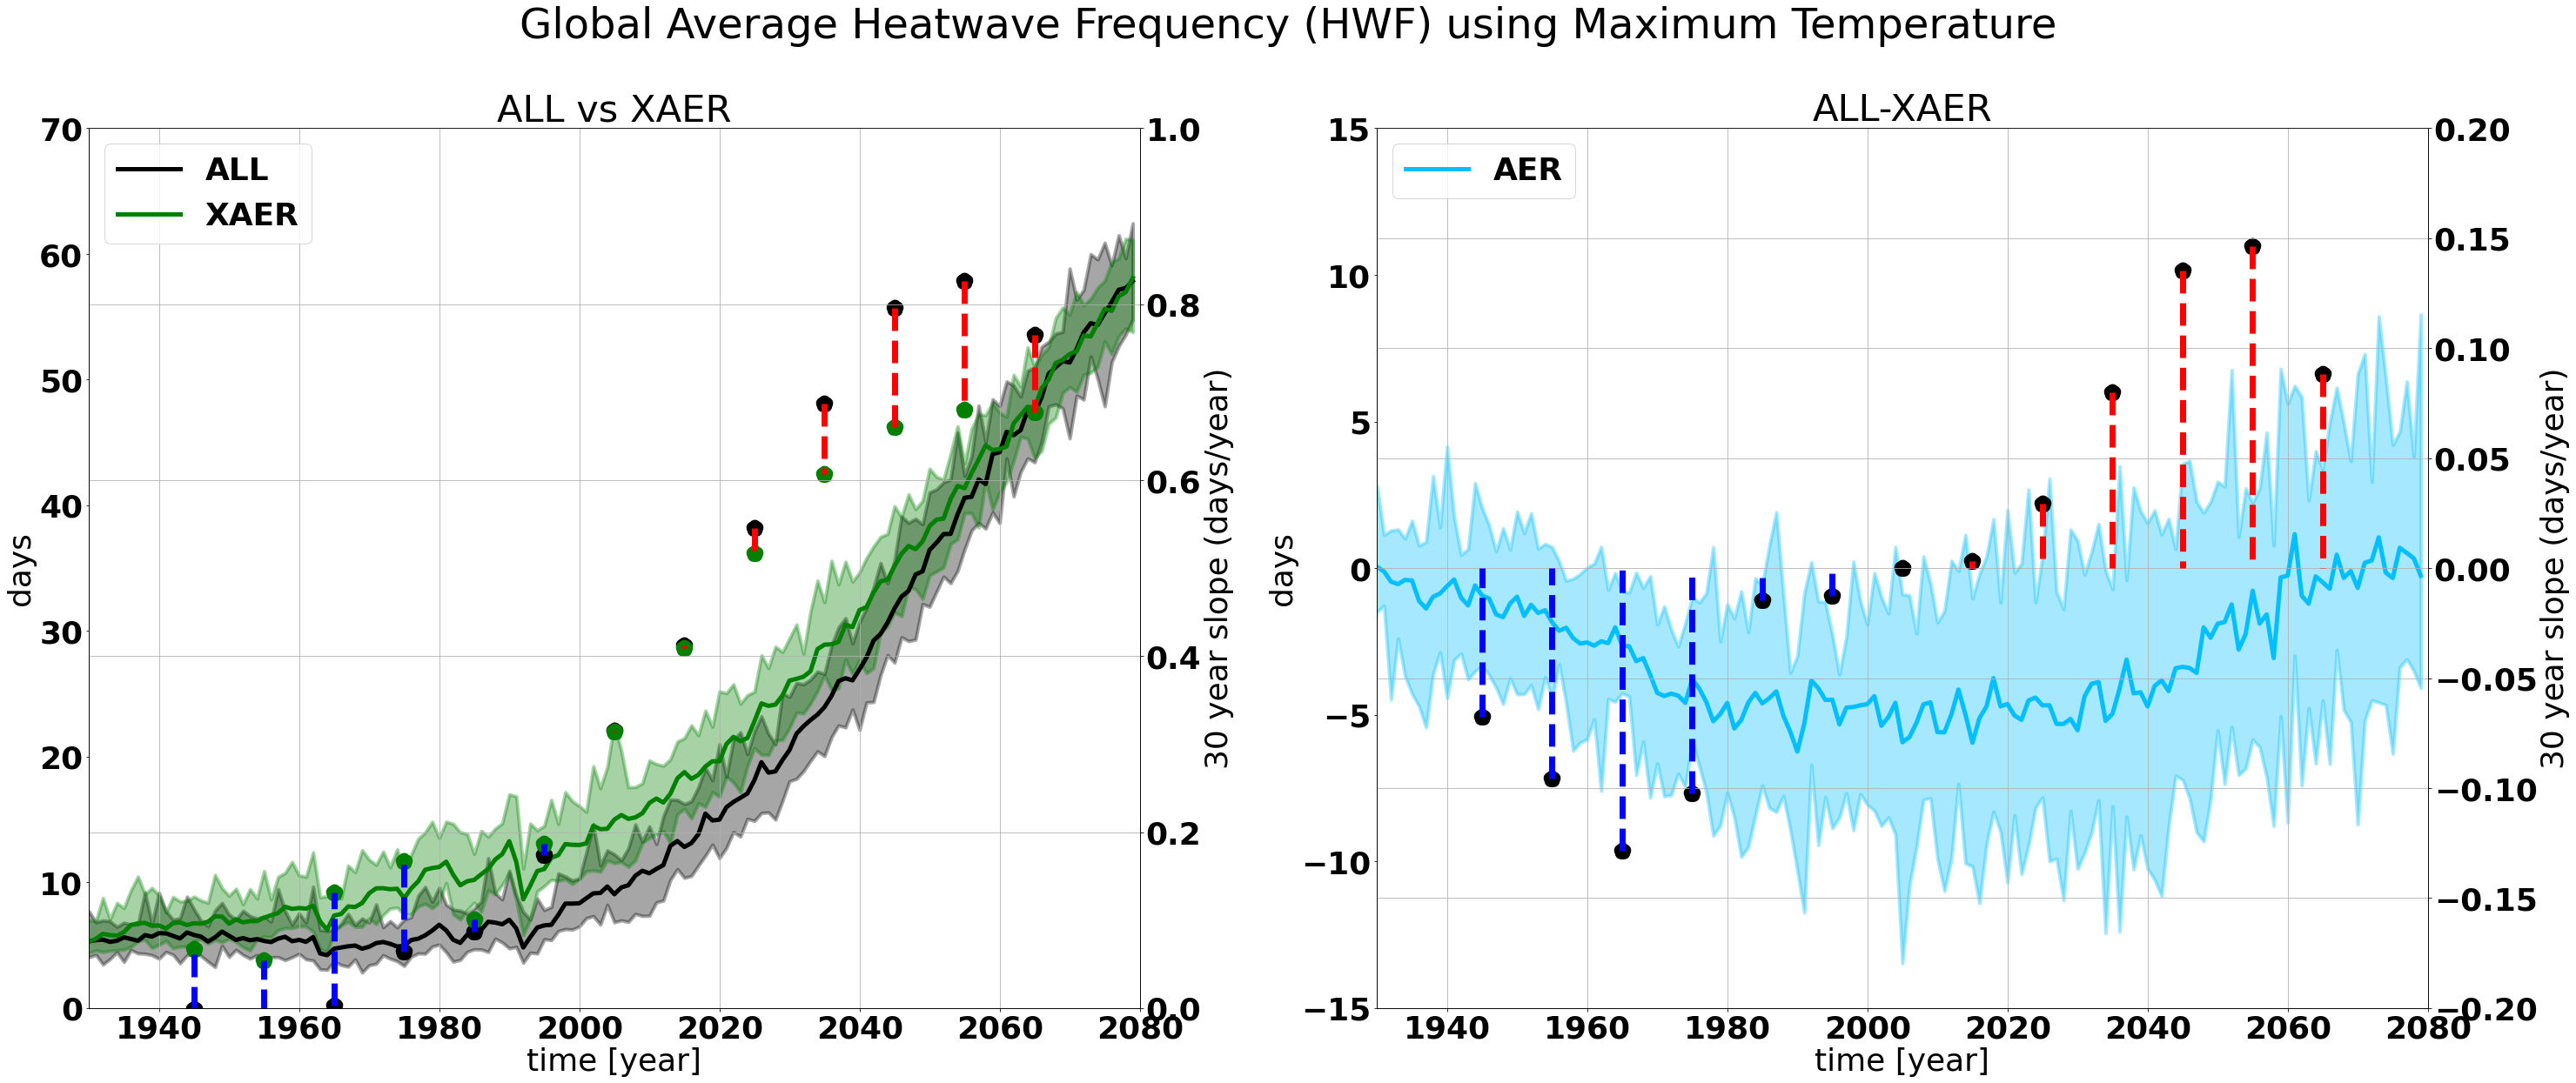

In [11]:
from paths import heat_out_trefht_tmin_members_1920_1950_CONTROL as tmin, heat_out_trefht_tmax_members_1920_1950_CONTROL as tmax
import xarray
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import colors
from matplotlib import rc
from regionmask.defined_regions import ar6

def poly_fit(ds):
    coeff = ds.mean(dim="member").polyfit(dim="time", deg=1)["polyfit_coefficients"].values
    print(f"{txt} -> {coeff}")
    return ds.time.values*coeff[0] + coeff[1]


def poly_fit_c(ds):
    coeff = ds.mean(dim="member").polyfit(dim="time", deg=1)["polyfit_coefficients"].values
    return coeff


def decadal_regressions(ds):
    # (Slope, x_init, x_final)
    #decades = [1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020, 2030, 2040, 2050]
    decades = [1945, 1955, 1965, 1975, 1985, 1995, 2005, 2015, 2025, 2035, 2045, 2055, 2065]
    regs = [poly_fit_c(ds.sel(time=slice(1930, 1960)))[0],
            poly_fit_c(ds.sel(time=slice(1940, 1970)))[0],
            poly_fit_c(ds.sel(time=slice(1950, 1980)))[0],
            poly_fit_c(ds.sel(time=slice(1960, 1990)))[0],
            poly_fit_c(ds.sel(time=slice(1970, 2000)))[0],
            poly_fit_c(ds.sel(time=slice(1980, 2010)))[0],
            poly_fit_c(ds.sel(time=slice(1990, 2020)))[0],
            poly_fit_c(ds.sel(time=slice(2000, 2030)))[0],
            poly_fit_c(ds.sel(time=slice(2010, 2040)))[0],
            poly_fit_c(ds.sel(time=slice(2020, 2050)))[0],
            poly_fit_c(ds.sel(time=slice(2030, 2060)))[0],
            poly_fit_c(ds.sel(time=slice(2040, 2070)))[0],
            poly_fit_c(ds.sel(time=slice(2050, 2079)))[0]]
    
    return decades, regs


def plot_regs(ax, all_regs, xaer_regs, decades):
    #ax.errorbar(decades, all_regs, xerr=[15]*len(all_regs), linewidth=reg_pt/3, color=all_c, alpha=span_a)
    ax.scatter(decades, all_regs, color=all_c, marker="*", linewidths=reg_pt)
    #ax.errorbar(decades, xaer_regs, xerr=[15]*len(xaer_regs), linewidth=reg_pt/3, color=xaer_c, alpha=span_a)
    ax.scatter(decades, xaer_regs, color=xaer_c, marker="*", linewidths=reg_pt)
    for index, year in enumerate(decades):
        if all_regs[index] < xaer_regs[index]:
            ax.plot([year, year], [all_regs[index], xaer_regs[index]], color="blue", linewidth=reg_pt/2, linestyle="--")
        else:
            ax.plot([year, year], [all_regs[index], xaer_regs[index]], color="red", linewidth=reg_pt/2, linestyle="--")

    
exp_num = "3136"
var = "HWF"

all_min, xghg_min, xaer_min = tmax()

#Mask for land
land_mask = xarray.open_dataset("../data/land_mask.nc")["__xarray_dataarray_variable__"].load()

all_min_hwf = xarray.open_mfdataset([path for path in all_min if exp_num in path], concat_dim="member", combine="nested")[f"{var}_tx90"].dt.days.sel(time=slice(1920, 2079)).where(land_mask>0).load().mean(dim="lat").mean(dim="lon")
xaer_min_hwf = xarray.open_mfdataset([path for path in xaer_min if exp_num in path], concat_dim="member", combine="nested")[f"{var}_tx90"].dt.days.sel(time=slice(1920, 2079)).where(land_mask>0).load().mean(dim="lat").mean(dim="lon")

decades, all_min_hwf_r = decadal_regressions(all_min_hwf)
decades, xaer_min_hwf_r = decadal_regressions(xaer_min_hwf)
decades, aer_min_hwf_r = decadal_regressions(all_min_hwf - xaer_min_hwf)

rc('font', **{'family': 'normal', 'weight': 'bold', 'size': 36})
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(42, 18), facecolor='w')
f.suptitle(f"Global Average Heatwave Frequency ({var}) using Maximum Temperature", fontsize=48)
plt.rcParams['axes.autolimit_mode'] = 'round_numbers'

mean_lw = 5
mean_bls = "-"
span_a = 0.3
bls_a = 0.35
reg_pt = 14.0
all_c = "black"
xaer_c = "green"
bls_lw = 4

all_min_hwf.mean(dim="member").plot(ax=ax1, linewidth=mean_lw, color=all_c, label="ALL")
xaer_min_hwf.mean(dim="member").plot(ax=ax1, linewidth=mean_lw, color=xaer_c, label="XAER")
ax1.fill_between(all_min_hwf.time, all_min_hwf.min(dim="member"), all_min_hwf.max(dim="member"), color=all_c, linestyle=mean_bls, linewidth=bls_lw, alpha=bls_a)
ax1.fill_between(xaer_min_hwf.time, xaer_min_hwf.min(dim="member"), xaer_min_hwf.max(dim="member"), color=xaer_c, linestyle=mean_bls, linewidth=bls_lw, alpha=bls_a)
ax11 = ax1.twinx()
plot_regs(ax11, all_min_hwf_r, xaer_min_hwf_r, decades)
ax11.grid(axis='both')
ax1.grid(axis='x')
ax1.legend(loc='upper left')
ax11.set_ylabel('30 year slope (days/year)')
ax11.set_title("ALL vs XAER")

aer = (all_min_hwf - xaer_min_hwf)
aer.mean(dim="member").plot(ax=ax2, linewidth=mean_lw, color="deepskyblue", label="AER")
ax2.fill_between(aer.time, aer.min(dim="member"), aer.max(dim="member"), color="deepskyblue", linestyle=mean_bls, linewidth=bls_lw, alpha=bls_a)
ax22 = ax2.twinx()
ax22.scatter(decades, aer_min_hwf_r, color="black", marker="*", linewidths=reg_pt)
for index, year in enumerate(decades):
    value = all_min_hwf_r[index] - xaer_min_hwf_r[index]
    if value > 0:
        color = "red"
    else:
        color = "blue"
    ax22.plot([year, year], [value, 0], color=color, linewidth=reg_pt/2, linestyle="--")

ax22.grid(axis='both')
ax2.grid(axis='x')
ax2.legend(loc='upper left')
ax22.set_ylabel('30 year slope (days/year)')
ax22.set_title("ALL-XAER")

# # Plot significance boundaries
ax1.plot([1936, 1936], [0, 100], linestyle=(0, (3, 1, 1, 1, 1, 1)), color="deepskyblue", linewidth=mean_lw)
ax1.plot([2049, 2049], [0, 100], linestyle=(0, (3, 1, 1, 1, 1, 1)), color="deepskyblue", linewidth=mean_lw)

ax11.set_ylim(0, 1)
ax1.set_ylim(0, 70)
ax11.set_xlim(1930, 2080)

ax22.set_ylim(-0.2, 0.2)
ax2.set_ylim(-15, 15)
ax22.set_xlim(1930, 2080)

f.tight_layout()

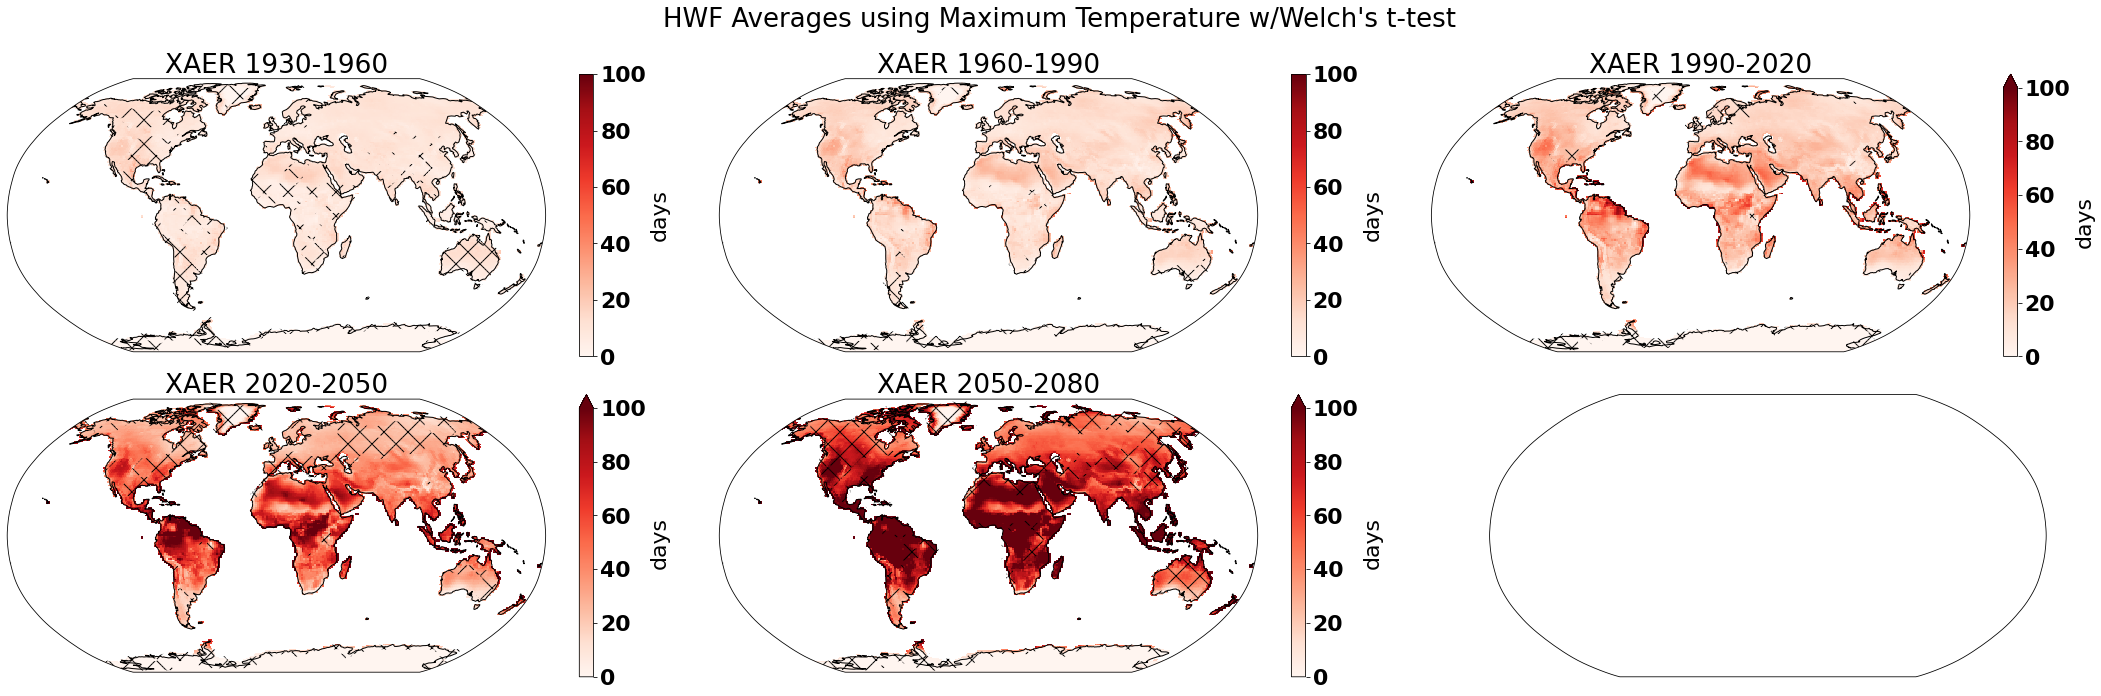

In [166]:
from paths import heat_out_trefht_tmin_members_1920_1950_CONTROL as tmin, heat_out_trefht_tmax_members_1920_1950_CONTROL as tmax, land_mask
import xarray
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import colors
from matplotlib import rc
import matplotlib.patches as mpatches
from analysis import t_test_mask
import numpy as np
from scipy.stats import ttest_ind


def sig_mask(all_ds, xaer_ds):
    
    def welch_t_test(all_pt, xaer_pt, lat, lon):
        # Confirmed that Sarah's modified t test is just a welches t test using my own code
        t_val, p_val = ttest_ind(all_pt, xaer_pt, equal_var=False)
        return ((lat, lon), p_val)
        
    #print("Converting to numpy array...")
    # (member, time, lat, lon)
    all_array = all_ds.values
    xaer_array = xaer_ds.values
    #print("Done.")
    
    results = []
    #print(f"Preforming test, modified={modified}")
    for lati, lat in enumerate(all_ds.lat.values):
        for loni, lon in enumerate(all_ds.lon.values):
            all_pt = all_array[0:all_ds["member"].size, 0:all_ds["time"].size, lati, loni].flatten()
            xaer_pt = xaer_array[0:xaer_ds["member"].size, 0:xaer_ds["time"].size, lati, loni].flatten()
            results.append(welch_t_test(all_pt, xaer_pt, lat, lon))
    
    if len(results) == all_min.lat.size*all_min.lon.size:
        #print("Shapes match, converting back to xarray...")
        pass
    else:
        raise RuntimeError(f'The mask size does not match the original dataset size: {len(mask)} != {all_min.lat.size*all_min.lon.size}')
    
    # Recycle ALL array
    return_array = (all_ds.mean(dim="member").mean(dim="time").load() * 0).rename("p-value")
    for index, ((lat, lon), value) in enumerate(results):
        return_array.loc[dict(lat=lat, lon=lon)] = value
    
    return return_array

exp_num = "3136"

vmin = 0
vmax = 100
cmap = "Reds"
var = "HWF"

sigmas = 2
modified = False

all_min, xghg_min, xaer_min = tmax()
land_m = xarray.open_dataset(land_mask())["__xarray_dataarray_variable__"]
all_min = xarray.open_mfdataset([path for path in all_min if exp_num in path], concat_dim="member", combine="nested")[f"{var}_tx90"].dt.days.sel(time=slice(1920,2079))
xaer_min = xarray.open_mfdataset([path for path in xaer_min if exp_num in path], concat_dim="member", combine="nested")[f"{var}_tx90"].dt.days.sel(time=slice(1920,2079))
ds_min = (xaer_min.mean(dim="member")).where(land_m > 0) #  - xaer_min.mean(dim="member")
ds_min = ds_min.assign_coords(lon=(((ds_min.lon + 180) % 360) - 180)).sortby('lon').load()

rc('font', **{'family': 'normal', 'weight': 'bold', 'size': 22})
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(30, 10), facecolor='w', subplot_kw={'projection': ccrs.Robinson()})
f.suptitle(f"{var} Averages using Maximum Temperature w/Welch's t-test ", fontsize=26)

def region_plotting(map_ax, ds, dummy):
    """
    Adds pink boxes to each map
    
    """
    edge_s = 2
    edge_c = "#F70FD8"
    edge_ls = "--"
    
    map_ax.add_patch(mpatches.Rectangle(xy=[-20, 35], width=80, height=30, fill=False, edgecolor=edge_c, linestyle=edge_ls, linewidth=edge_s, transform=ccrs.PlateCarree()))
    europe = ds.where(ds.lat>35).where(ds.lat<65).where(ds.lon>-20).where(ds.lon<60).mean(dim="lat").mean(dim="lon").load()

    map_ax.add_patch(mpatches.Rectangle(xy=[-100, 25], width=40, height=30, fill=False, edgecolor=edge_c, linestyle=edge_ls, linewidth=edge_s, transform=ccrs.PlateCarree()))
    e_na = ds.where(ds.lat>25).where(ds.lat<55).where(ds.lon>-100).where(ds.lon<-60).mean(dim="lat").mean(dim="lon").load()
    
    map_ax.add_patch(mpatches.Rectangle(xy=[-90, 10], width=35, height=-35, fill=False, edgecolor=edge_c, linestyle=edge_ls, linewidth=edge_s, transform=ccrs.PlateCarree()))
    trop_s_amer = ds.where(ds.lat>-25).where(ds.lat<10).where(ds.lon>-90).where(ds.lon<-55).mean(dim="lat").mean(dim="lon").load()
    
    map_ax.add_patch(mpatches.Rectangle(xy=[-10, 15], width=55, height=-35, fill=False, edgecolor=edge_c, linestyle=edge_ls, linewidth=edge_s, transform=ccrs.PlateCarree()))
    africa = ds.where(ds.lat>-20).where(ds.lat<15).where(ds.lon>-10).where(ds.lon<45).mean(dim="lat").mean(dim="lon").load()
    
    map_ax.add_patch(mpatches.Rectangle(xy=[65, 5], width=55, height=35, fill=False, edgecolor=edge_c, linestyle=edge_ls, linewidth=edge_s, transform=ccrs.PlateCarree()))
    se_asia = ds.where(ds.lat>20).where(ds.lat<50).where(ds.lon>95).where(ds.lon<130).mean(dim="lat").mean(dim="lon").load()
    
    return (europe, e_na, trop_s_amer, africa, se_asia)
region_avgs = {}

ds_min.sel(time=slice(1930, 1960)).mean(dim="time").plot(ax=ax1, transform=ccrs.PlateCarree(), vmax=vmax, vmin=vmin, cmap=cmap)
mask1 = sig_mask(all_min.sel(time=slice(1930, 1960)), xaer_min.sel(time=slice(1930, 1960)))
mask1 = mask1.where(mask1>0.05).where(land_m>0)
ax1.set_title("XAER 1930-1960")
#region_avgs["1"] = region_plotting(ax1, ds_min.sel(time=slice(1930, 1960)), False)

ds_min.sel(time=slice(1960, 1990)).mean(dim="time").plot(ax=ax2, transform=ccrs.PlateCarree(), vmax=vmax, vmin=vmin, cmap=cmap)
mask2 = sig_mask(all_min.sel(time=slice(1960, 1990)), xaer_min.sel(time=slice(1960, 1990)))
mask2 = mask2.where(mask2>0.05).where(land_m>0)
ax2.set_title("XAER 1960-1990")
#region_avgs["2"] = region_plotting(ax2, ds_min.sel(time=slice(1960, 1990)), False)

ds_min.sel(time=slice(1990, 2020)).mean(dim="time").plot(ax=ax3, transform=ccrs.PlateCarree(), vmax=vmax, vmin=vmin, cmap=cmap)
mask3 = sig_mask(all_min.sel(time=slice(1990, 2020)), xaer_min.sel(time=slice(1990, 2020)))
mask3 = mask3.where(mask3>0.05).where(land_m>0)
ax3.set_title("XAER 1990-2020")
#region_avgs["3"] = region_plotting(ax3, ds_min.sel(time=slice(1990, 2020)), False)

ds_min.sel(time=slice(2020, 2050)).mean(dim="time").plot(ax=ax4, transform=ccrs.PlateCarree(), vmax=vmax, vmin=vmin, cmap=cmap)
mask4 = sig_mask(all_min.sel(time=slice(2020, 2050)), xaer_min.sel(time=slice(2020, 2050)))
mask4 = mask4.where(mask4>0.05).where(land_m>0)
ax4.set_title("XAER 2020-2050")
#region_avgs["4"] = region_plotting(ax4, ds_min.sel(time=slice(2020, 2050)), False)

ds_min.sel(time=slice(2050, 2079)).mean(dim="time").plot(ax=ax5, transform=ccrs.PlateCarree(), vmax=vmax, vmin=vmin, cmap=cmap)
mask5 = sig_mask(all_min.sel(time=slice(2050, 2079)), xaer_min.sel(time=slice(2050, 2079)))
mask5 = mask5.where(mask5>0.05).where(land_m>0)
ax5.set_title("XAER 2050-2080")
#region_avgs["5"] = region_plotting(ax5, ds_min.sel(time=slice(2050, 2079)), False)

X, Y = np.meshgrid(mask1.lon, mask1.lat)
ax1.hexbin(X.reshape(-1), Y.reshape(-1), mask1.data.reshape(-1), hatch='x', alpha=0, transform=ccrs.PlateCarree())
ax2.hexbin(X.reshape(-1), Y.reshape(-1), mask2.data.reshape(-1), hatch='x', alpha=0, transform=ccrs.PlateCarree())
ax3.hexbin(X.reshape(-1), Y.reshape(-1), mask3.data.reshape(-1), hatch='x', alpha=0, transform=ccrs.PlateCarree())
ax4.hexbin(X.reshape(-1), Y.reshape(-1), mask4.data.reshape(-1), hatch='x', alpha=0, transform=ccrs.PlateCarree())
ax5.hexbin(X.reshape(-1), Y.reshape(-1), mask5.data.reshape(-1), hatch='x', alpha=0, transform=ccrs.PlateCarree())

# edge_c = "lime"
# edge_ls = "--"
# edge_s = 2
# ax4.add_patch(mpatches.Rectangle(xy=[-20, 35], width=80, height=30, fill=False, edgecolor=edge_c, linestyle=edge_ls, linewidth=edge_s, transform=ccrs.PlateCarree()))
# ax4.add_patch(mpatches.Rectangle(xy=[-100, 25], width=40, height=30, fill=False, edgecolor=edge_c, linestyle=edge_ls, linewidth=edge_s, transform=ccrs.PlateCarree()))
# ax4.add_patch(mpatches.Rectangle(xy=[0, 15], width=10, height=15, fill=False, edgecolor=edge_c, linestyle=edge_ls, linewidth=edge_s, transform=ccrs.PlateCarree()))


ax1.coastlines()
ax2.coastlines()
ax3.coastlines()
ax4.coastlines()
ax5.coastlines()

f.tight_layout()

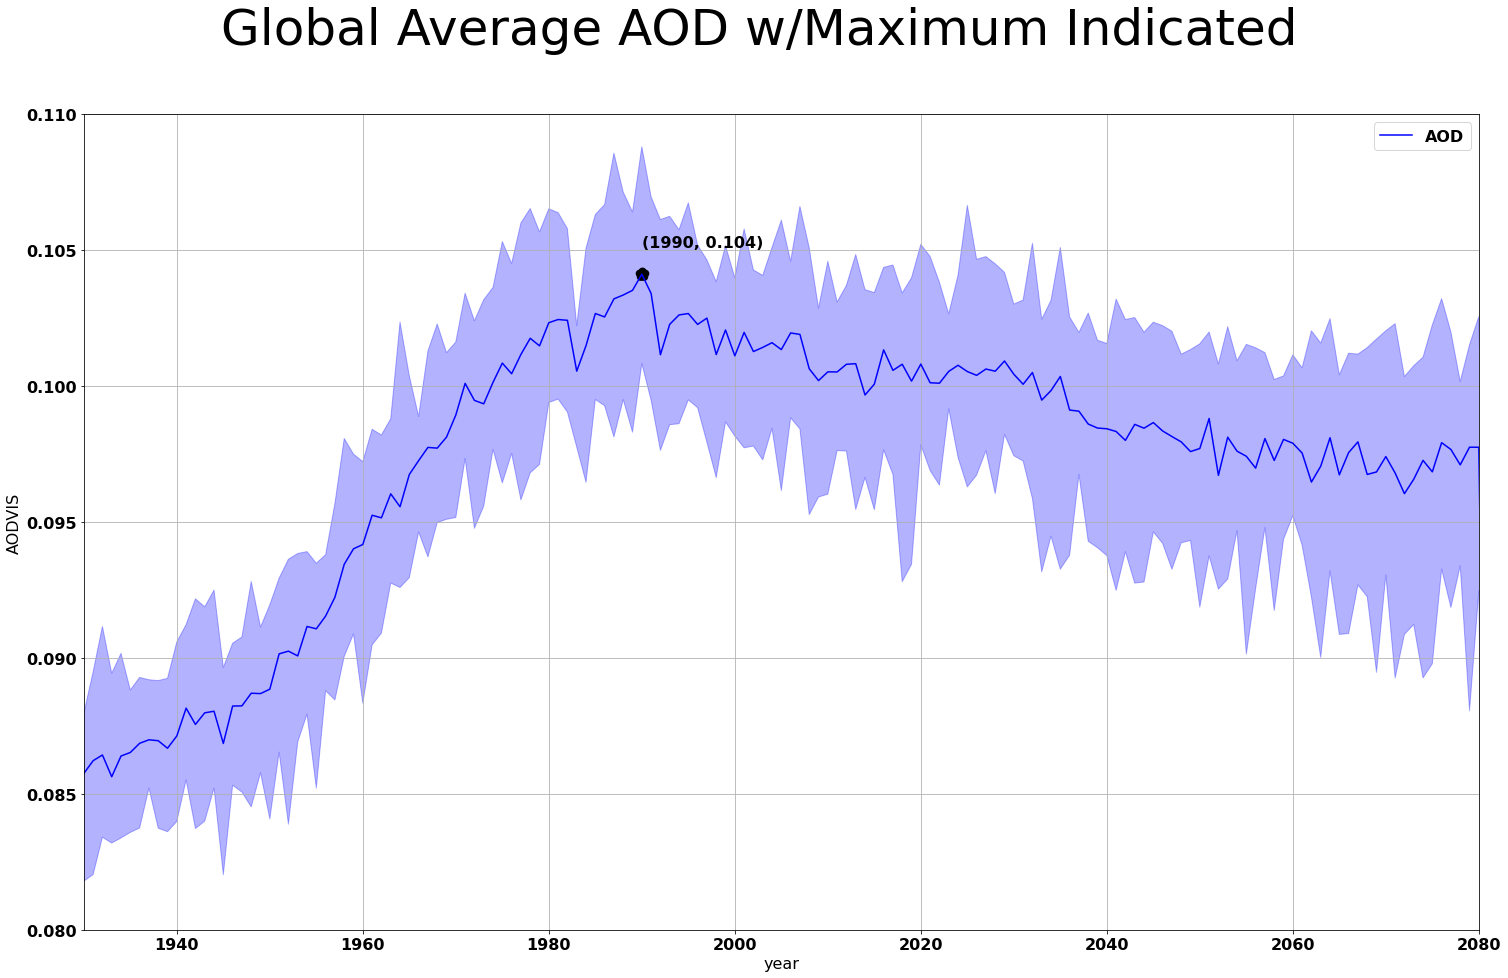

In [46]:
import xarray
from paths import heat_out_trefht_tmax_members_1920_1950_CONTROL as hwmax, aod_vis_download as aod_raw, aod_vis_concatenated as aod_members, DIR_PATH
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import rc

land_mask = xarray.open_dataset("../data/land_mask.nc")["__xarray_dataarray_variable__"].load()
aod_data = xarray.open_mfdataset(aod_members(), concat_dim="member", combine="nested")
aod_data = aod_data["AODVIS"].groupby("time.year").mean().where(land_mask>0).mean(dim="lon").mean(dim="lat").load()

plt.rcParams['axes.autolimit_mode'] = 'round_numbers'
f, ax = plt.subplots(1, 1, figsize=(25, 15), facecolor='w')
f.suptitle("Global Average AOD w/Maximum Indicated", fontsize=50)
font = {'weight': 'bold',
        'size': 16}
rc('font', **font)
aod_color = "blue"
aer_color = "red"

aod_data.mean(dim="member").plot(ax=ax, color=aod_color, label="AOD")
ax.fill_between(aod_data.year, aod_data.min(dim="member"), aod_data.max(dim="member"), alpha=0.3, color=aod_color)
max_year = max(aod_data.mean(dim="member")).year.values
max_val = aod_data.mean(dim="member").max().values
ax.scatter(max_year, max_val, marker="*", linewidth=8, color="black")
ax.text(max_year, max_val + 0.001, f"({max_year}, {max_val.round(3)})")

ax.set_xlim(1930, 2080)
ax.set_ylim(0.08, 0.11)
ax.legend()
ax.grid()

In [ ]:
import xarray
import imageio
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from paths import heat_out_trefht_tmin_members_1920_1950_CONTROL as tmin, land_mask

all_minp, xghg_minp, xaer_minp = tmin()
land_m = xarray.open_dataset(land_mask())["__xarray_dataarray_variable__"]
all_min = xarray.open_mfdataset([path for path in all_minp if exp_num in path], concat_dim="member", combine="nested")[f"{var}_tn90"].dt.days.sel(time=slice(1920,2079))
xaer_min = xarray.open_mfdataset([path for path in xaer_minp if exp_num in path], concat_dim="member", combine="nested")[f"{var}_tn90"].dt.days.sel(time=slice(1920,2079))
all_min = all_min.where(land_m > 0)
xaer_min = xaer_min.where(land_m > 0)

aod_data = xarray.open_mfdataset(aod_members(), concat_dim="member", combine="nested").mean(dim="member")
aod_data = aod_data["AODVIS"].groupby("time.year").mean().load()

def sig_mask(all_ds, xaer_ds):
    
    def welch_t_test(all_pt, xaer_pt, lat, lon):
        # Confirmed that Sarah's modified t test is just a welches t test using my own code
        t_val, p_val = ttest_ind(all_pt, xaer_pt, equal_var=False)
        return ((lat, lon), p_val)
        
    #print("Converting to numpy array...")
    # (member, time, lat, lon)
    all_array = all_ds.values
    xaer_array = xaer_ds.values
    #print("Done.")
    
    results = []
    #print(f"Preforming test, modified={modified}")
    for lati, lat in enumerate(all_ds.lat.values):
        for loni, lon in enumerate(all_ds.lon.values):
            all_pt = all_array[0:all_ds["member"].size, lati, loni].flatten()
            xaer_pt = xaer_array[0:xaer_ds["member"].size, lati, loni].flatten()
            results.append(welch_t_test(all_pt, xaer_pt, lat, lon))
    
    if len(results) == all_min.lat.size*all_min.lon.size:
        #print("Shapes match, converting back to xarray...")
        pass
    else:
        raise RuntimeError(f'The mask size does not match the original dataset size: {len(mask)} != {all_min.lat.size*all_min.lon.size}')
    
    # Recycle ALL array
    return_array = (all_ds.mean(dim="member").load() * 0).rename("p-value")
    for index, ((lat, lon), value) in enumerate(results):
        return_array.loc[dict(lat=lat, lon=lon)] = value
    
    return return_array

for year in aod_data.year.values:
    f, ax = plt.subplots(1, 1, figsize=(14, 7), facecolor='w', subplot_kw={'projection': ccrs.PlateCarree()})
    f.suptitle(f"Evolution of AOD relative to 1920: {year}", fontsize=30)

    mask = sig_mask(all_min.sel(time=year), xaer_min.sel(time=year))
    mask = mask.where(mask<0.05).where(land_m>0)
    
    (aod_data.sel(year=year) - aod_data.sel(year=1920)).plot(ax=ax, vmax=0.1, vmin=0, cmap="Blues", rasterized=True)
    X, Y = np.meshgrid(mask.lon, mask.lat)
    ax.hexbin(X.reshape(-1), Y.reshape(-1), mask.data.reshape(-1), hatch='x', alpha=0, transform=ccrs.PlateCarree())
    
    ax.coastlines()
    f.savefig(f"./tmp/{year}.png")
    plt.close()
    print(year, end=", ")

# Build GIF
from os import listdir
with imageio.get_writer('animation.gif', mode='I') as writer:
    paths = [f"./tmp/{path}" for path in listdir("tmp") if ".png" in path]
    paths.sort()
    for filename in paths:
        image = imageio.imread(filename)
        writer.append_data(image)

In [24]:
from paths import heat_out_trefht_tmin_members_1920_1950_CONTROL as tmin, heat_out_trefht_tmax_members_1920_1950_CONTROL as tmax, aod_vis_xaer_concatenated, aod_vis_all_concatenated

all_aod = xarray.open_mfdataset(aod_vis_all_concatenated(), combine='nested', concat_dim="member")["AODVIS"].groupby("time.year").mean().load()
xaer_aod = xarray.open_mfdataset(aod_vis_xaer_concatenated(), combine='nested', concat_dim="member")["AODVIS"].load()
aod_ds = all_aod - xaer_aod

land_mask = xarray.open_dataset("../data/land_mask.nc")["__xarray_dataarray_variable__"].load()
aod_data = aod_ds.sel(year=slice(1930, 2079)).where(land_mask > 0).mean(dim="lat").mean(dim="lon")

ImportError: cannot import name 'aod_vis_xaer_concatenated' from 'paths' (/home/persad_research/heat_research/heat-research-scripts/paths.py)

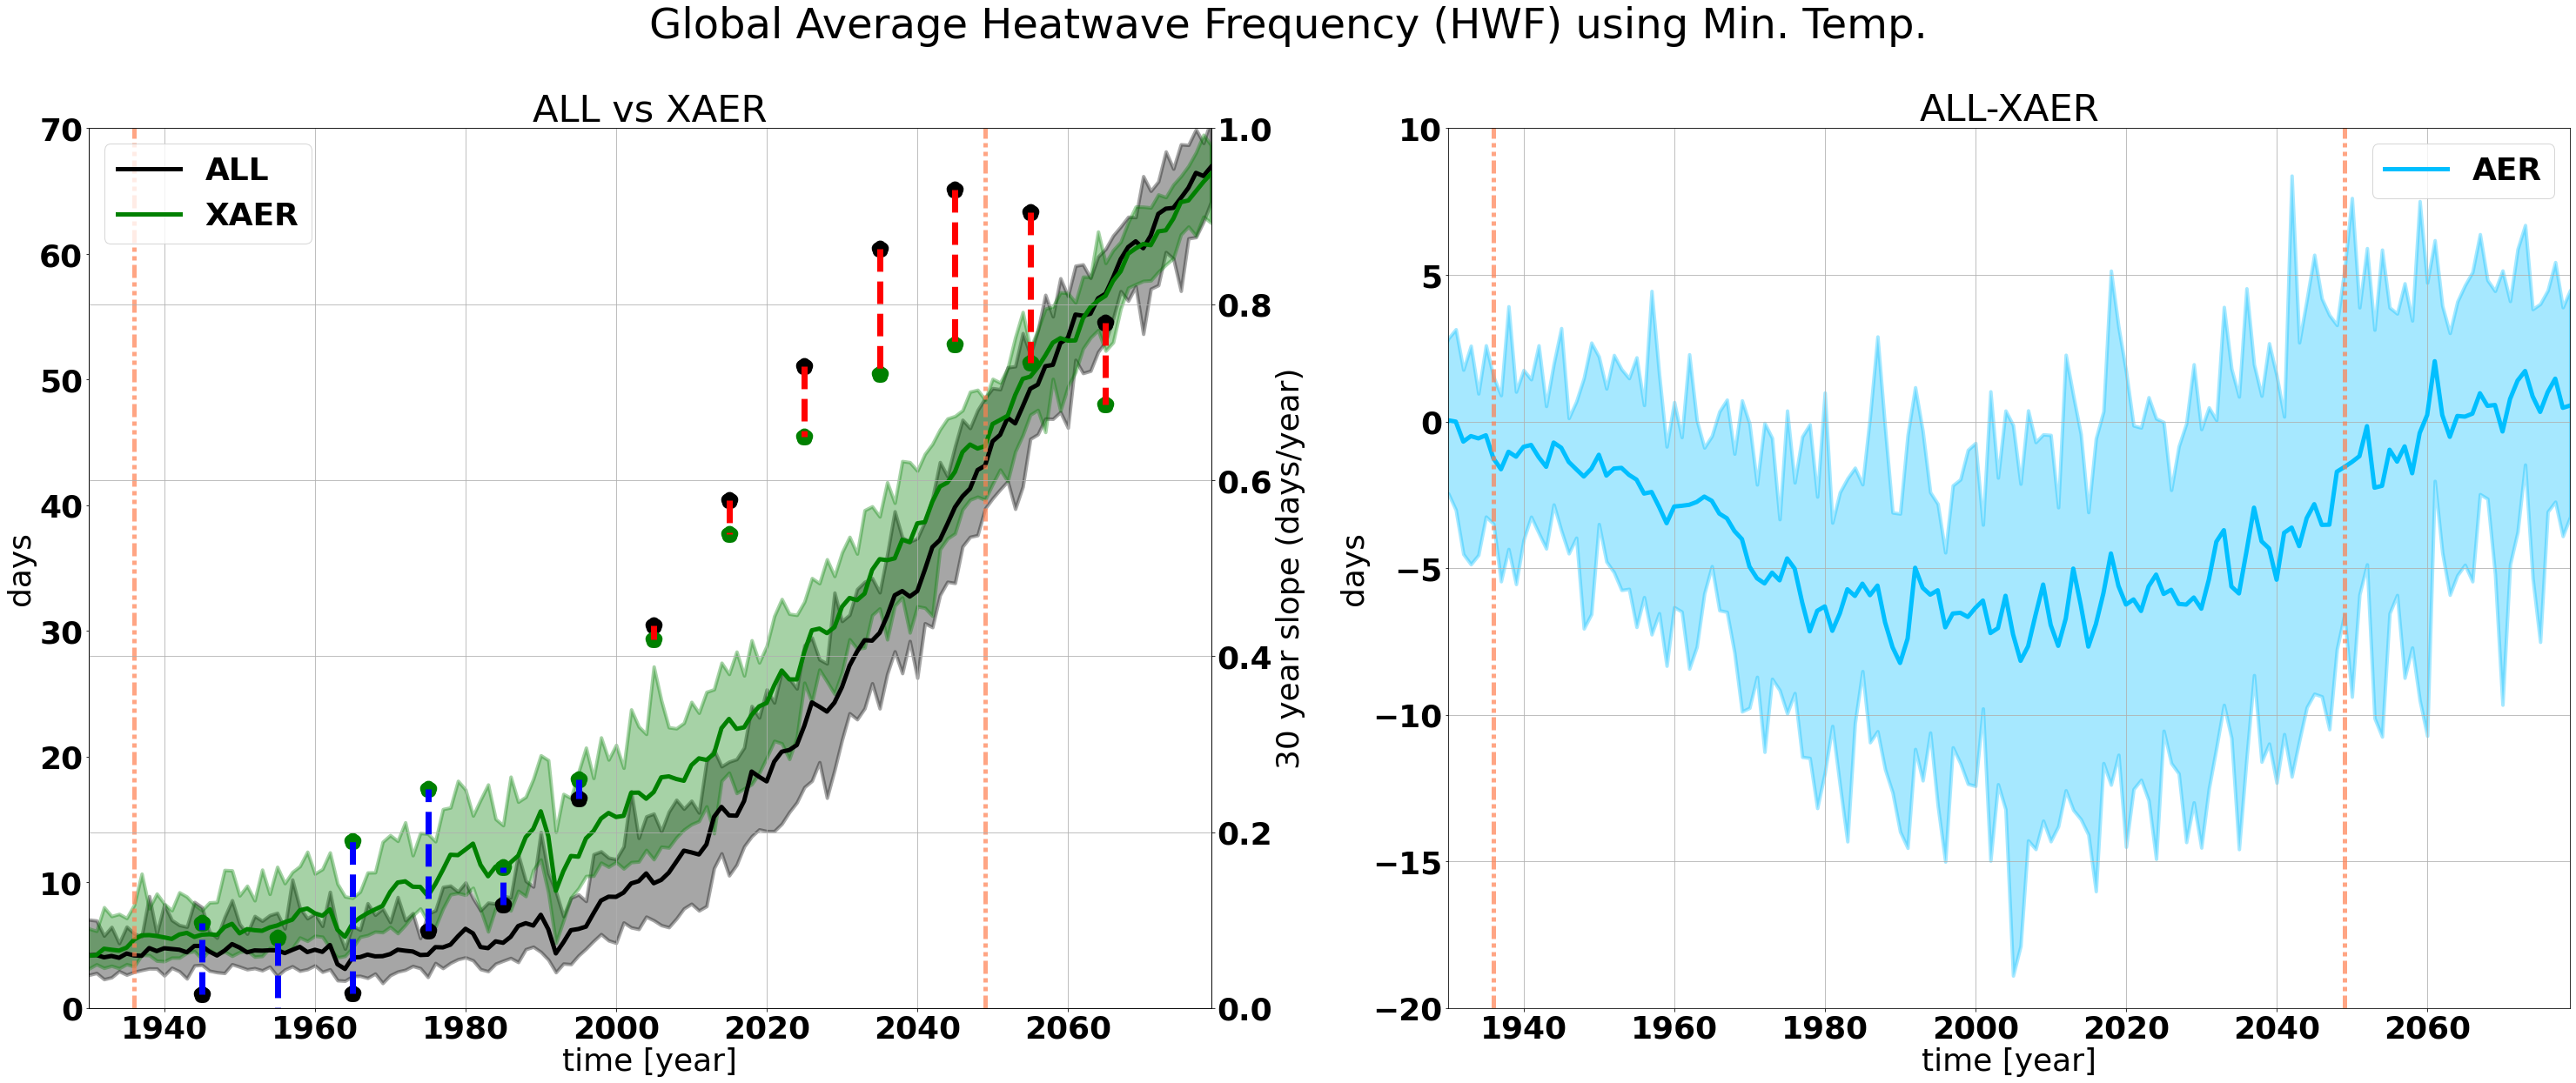

In [138]:
from paths import heat_out_trefht_tmin_members_1920_1950_CONTROL as tmin, heat_out_trefht_tmax_members_1920_1950_CONTROL as tmax, aod_vis_xaer_concatenated, aod_vis_all_concatenated
import xarray
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import colors
from matplotlib import rc

def poly_fit(ds):
    coeff = ds.mean(dim="member").polyfit(dim="time", deg=1)["polyfit_coefficients"].values
    print(f"{txt} -> {coeff}")
    return ds.time.values*coeff[0] + coeff[1]


def poly_fit_c(ds):
    coeff = ds.mean(dim="member").polyfit(dim="time", deg=1)["polyfit_coefficients"].values
    return coeff


def decadal_regressions(ds):
    # (Slope, x_init, x_final)
    #decades = [1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020, 2030, 2040, 2050]
    decades = [1945, 1955, 1965, 1975, 1985, 1995, 2005, 2015, 2025, 2035, 2045, 2055, 2065]
    regs = [poly_fit_c(ds.sel(time=slice(1930, 1960)))[0],
            poly_fit_c(ds.sel(time=slice(1940, 1970)))[0],
            poly_fit_c(ds.sel(time=slice(1950, 1980)))[0],
            poly_fit_c(ds.sel(time=slice(1960, 1990)))[0],
            poly_fit_c(ds.sel(time=slice(1970, 2000)))[0],
            poly_fit_c(ds.sel(time=slice(1980, 2010)))[0],
            poly_fit_c(ds.sel(time=slice(1990, 2020)))[0],
            poly_fit_c(ds.sel(time=slice(2000, 2030)))[0],
            poly_fit_c(ds.sel(time=slice(2010, 2040)))[0],
            poly_fit_c(ds.sel(time=slice(2020, 2050)))[0],
            poly_fit_c(ds.sel(time=slice(2030, 2060)))[0],
            poly_fit_c(ds.sel(time=slice(2040, 2070)))[0],
            poly_fit_c(ds.sel(time=slice(2050, 2079)))[0]]
    
    return decades, regs


def plot_regs(ax, all_regs, xaer_regs, decades):
    #ax.errorbar(decades, all_regs, xerr=[15]*len(all_regs), linewidth=reg_pt/3, color=all_c, alpha=span_a)
    ax.scatter(decades, all_regs, color=all_c, marker="*", linewidths=reg_pt)
    #ax.errorbar(decades, xaer_regs, xerr=[15]*len(xaer_regs), linewidth=reg_pt/3, color=xaer_c, alpha=span_a)
    ax.scatter(decades, xaer_regs, color=xaer_c, marker="*", linewidths=reg_pt)
    for index, year in enumerate(decades):
        if all_regs[index] < xaer_regs[index]:
            ax.plot([year, year], [all_regs[index], xaer_regs[index]], color="blue", linewidth=reg_pt/2, linestyle="--")
        else:
            ax.plot([year, year], [all_regs[index], xaer_regs[index]], color="red", linewidth=reg_pt/2, linestyle="--")

    
exp_num = "3136"
var = "HWF"

all_min, xghg_min, xaer_min = tmin()

#Mask for land
land_mask = xarray.open_dataset("../data/land_mask.nc")["__xarray_dataarray_variable__"].load()

all_min_hwf = xarray.open_mfdataset([path for path in all_min if exp_num in path], concat_dim="member", combine="nested")[f"{var}_tn90"].dt.days.sel(time=slice(1920, 2079)).where(land_mask>0).load().mean(dim="lat").mean(dim="lon")
xaer_min_hwf = xarray.open_mfdataset([path for path in xaer_min if exp_num in path], concat_dim="member", combine="nested")[f"{var}_tn90"].dt.days.sel(time=slice(1920, 2079)).where(land_mask>0).load().mean(dim="lat").mean(dim="lon")

decades, all_min_hwf_r = decadal_regressions(all_min_hwf)
decades, xaer_min_hwf_r = decadal_regressions(xaer_min_hwf)

rc('font', **{'family': 'normal', 'weight': 'bold', 'size': 36})
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(42, 18), facecolor='w')
f.suptitle(f"Global Average Heatwave Frequency ({var}) using Min. Temp.", fontsize=48)
plt.rcParams['axes.autolimit_mode'] = 'round_numbers'

mean_lw = 5
mean_bls = "-"
span_a = 0.3
bls_a = 0.35
reg_pt = 14.0
all_c = "black"
xaer_c = "green"
bls_lw = 4
aod_color = "blue"

all_min_hwf.mean(dim="member").plot(ax=ax1, linewidth=mean_lw, color=all_c, label="ALL")
xaer_min_hwf.mean(dim="member").plot(ax=ax1, linewidth=mean_lw, color=xaer_c, label="XAER")
ax1.fill_between(all_min_hwf.time, all_min_hwf.min(dim="member"), all_min_hwf.max(dim="member"), color=all_c, linestyle=mean_bls, linewidth=bls_lw, alpha=bls_a)
ax1.fill_between(xaer_min_hwf.time, xaer_min_hwf.min(dim="member"), xaer_min_hwf.max(dim="member"), color=xaer_c, linestyle=mean_bls, linewidth=bls_lw, alpha=bls_a)
ax11 = ax1.twinx()
plot_regs(ax11, all_min_hwf_r, xaer_min_hwf_r, decades)
ax11.grid(axis='both')
ax1.grid(axis='x')
ax1.legend(loc='upper left')
ax11.set_ylabel('30 year slope (days/year)')
ax11.set_title("ALL vs XAER")

aer = (all_min_hwf - xaer_min_hwf)
aer.mean(dim="member").plot(ax=ax2, linewidth=mean_lw, label="AER", color="deepskyblue")
ax2.fill_between(aer.time, aer.min(dim="member"), aer.max(dim="member"), color="deepskyblue", linestyle=mean_bls, linewidth=bls_lw, alpha=bls_a)

# Plot significance boundaries
color = "coral"
alpha=0.7
ax1.plot([1936, 1936], [0, 100], linestyle=(0, (3, 1, 1, 1, 1, 1)), color=color, linewidth=mean_lw, alpha=alpha)
ax1.plot([2049, 2049], [0, 100], linestyle=(0, (3, 1, 1, 1, 1, 1)), color=color, linewidth=mean_lw, alpha=alpha)
ax2.plot([1936, 1936], [-20, 20], linestyle=(0, (3, 1, 1, 1, 1, 1)), color=color, linewidth=mean_lw, alpha=alpha)
ax2.plot([2049, 2049], [-20, 20], linestyle=(0, (3, 1, 1, 1, 1, 1)), color=color, linewidth=mean_lw, alpha=alpha)

ax2.grid()
ax2.legend()
ax2.set_xlim(1930, 2079)
ax2.set_ylim(-20, 10)
ax2.set_title("ALL-XAER")

ax11.set_ylim(0, 1)
ax1.set_ylim(0, 70)
ax11.set_xlim(1930, 2079)

f.tight_layout()

In [152]:
period=slice(2006,2079)
(xaer_min_hwf.mean(dim="member").sel(time=period).mean() - all_min_hwf.mean(dim="member").sel(time=period).mean()) / all_min_hwf.mean(dim="member").sel(time=period).mean()

<xarray.DataArray 'days' ()>
array(0.08232147)

In [153]:
(np.mean(xaer_min_hwf_r[6:]) - np.mean(all_min_hwf_r[6:])) / np.mean(all_min_hwf_r[6:])

-0.13764392463846178

In [148]:
decades[6:]

[2005, 2015, 2025, 2035, 2045, 2055, 2065]

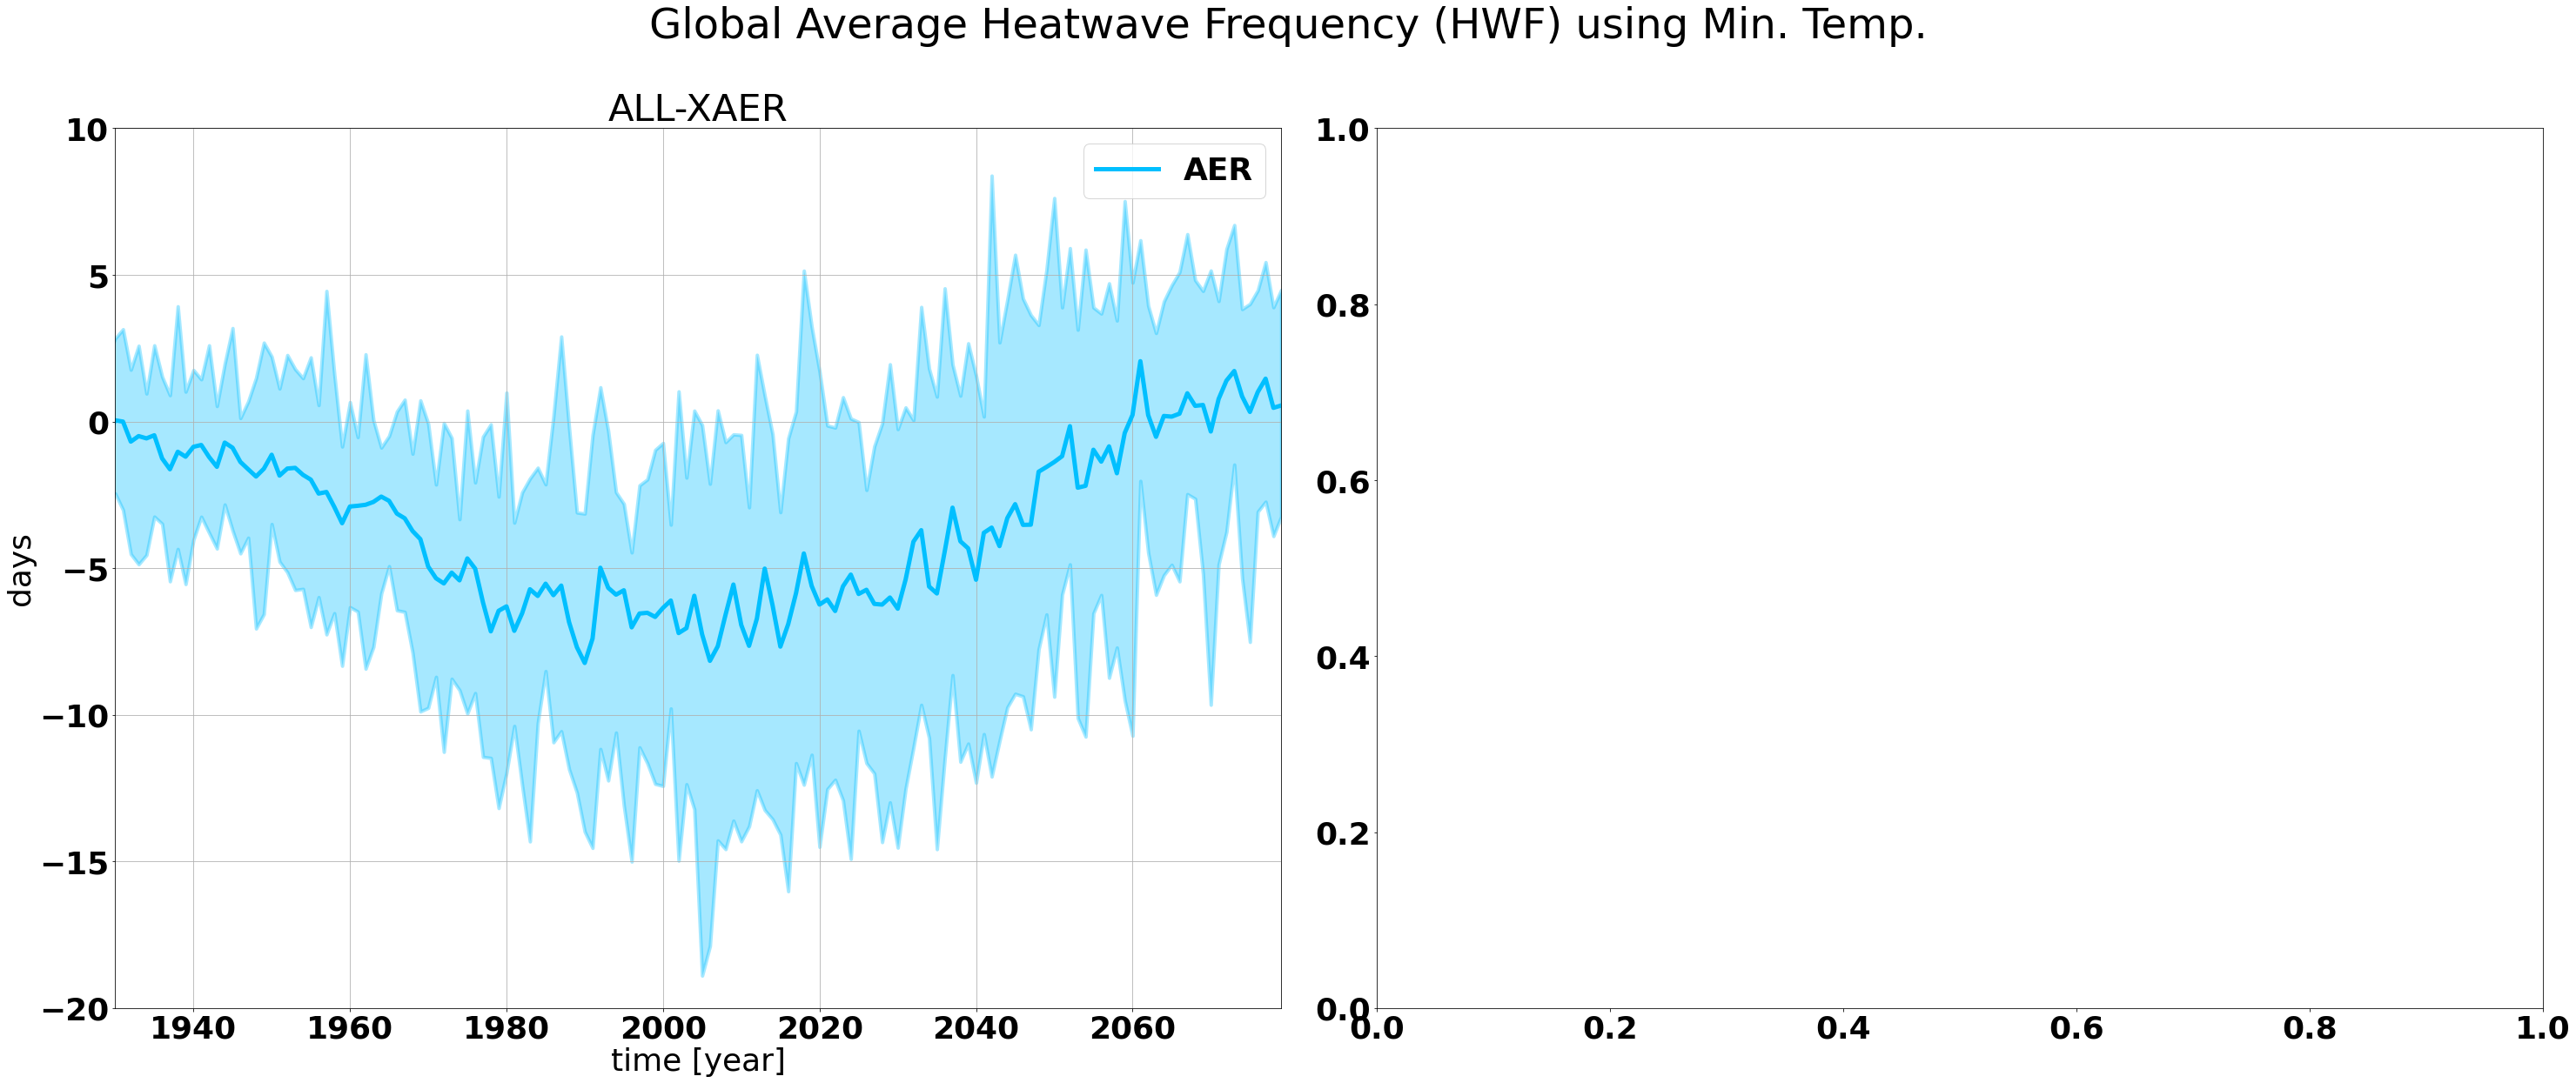

In [44]:
from paths import heat_out_trefht_tmin_members_1920_1950_CONTROL as tmin, heat_out_trefht_tmax_members_1920_1950_CONTROL as tmax, aod_vis_xaer_concatenated, aod_vis_all_concatenated
import xarray
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import colors
from matplotlib import rc

exp_num = "3136"
var = "HWF"

all_min, xghg_min, xaer_min = tmin()

#Mask for land
land_mask = xarray.open_dataset("../data/land_mask.nc")["__xarray_dataarray_variable__"].load()

all_min_hwf = xarray.open_mfdataset([path for path in all_min if exp_num in path], concat_dim="member", combine="nested")[f"{var}_tn90"].dt.days.sel(time=slice(1920, 2079)).where(land_mask>0).load().mean(dim="lat").mean(dim="lon")
xaer_min_hwf = xarray.open_mfdataset([path for path in xaer_min if exp_num in path], concat_dim="member", combine="nested")[f"{var}_tn90"].dt.days.sel(time=slice(1920, 2079)).where(land_mask>0).load().mean(dim="lat").mean(dim="lon")

decades, all_min_hwf_r = decadal_regressions(all_min_hwf)
decades, xaer_min_hwf_r = decadal_regressions(xaer_min_hwf)

rc('font', **{'family': 'normal', 'weight': 'bold', 'size': 36})
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(42, 18), facecolor='w')
f.suptitle(f"Global Average Heatwave Frequency ({var}) using Min. Temp.", fontsize=48)
plt.rcParams['axes.autolimit_mode'] = 'round_numbers'

mean_lw = 5
mean_bls = "-"
span_a = 0.3
bls_a = 0.35
reg_pt = 14.0
all_c = "black"
xaer_c = "green"
bls_lw = 4
aod_color = "blue"

aer = (all_min_hwf - xaer_min_hwf)
aer.mean(dim="member").plot(ax=ax1, linewidth=mean_lw, label="AER", color="deepskyblue")
ax1.fill_between(aer.time, aer.min(dim="member"), aer.max(dim="member"), color="deepskyblue", linestyle=mean_bls, linewidth=bls_lw, alpha=bls_a)
ax1.grid()
ax1.legend()
ax1.set_xlim(1930, 2079)
ax1.set_ylim(-20, 10)
ax1.set_title("ALL-XAER")

f.tight_layout()

In [59]:
aer.mean(dim="member").std()

<xarray.DataArray 'days' ()>
array(2.731509)

In [57]:
aer.mean(dim="member").sel(time=slice(2005, 2080)).std()

<xarray.DataArray 'days' ()>
array(2.95137791)

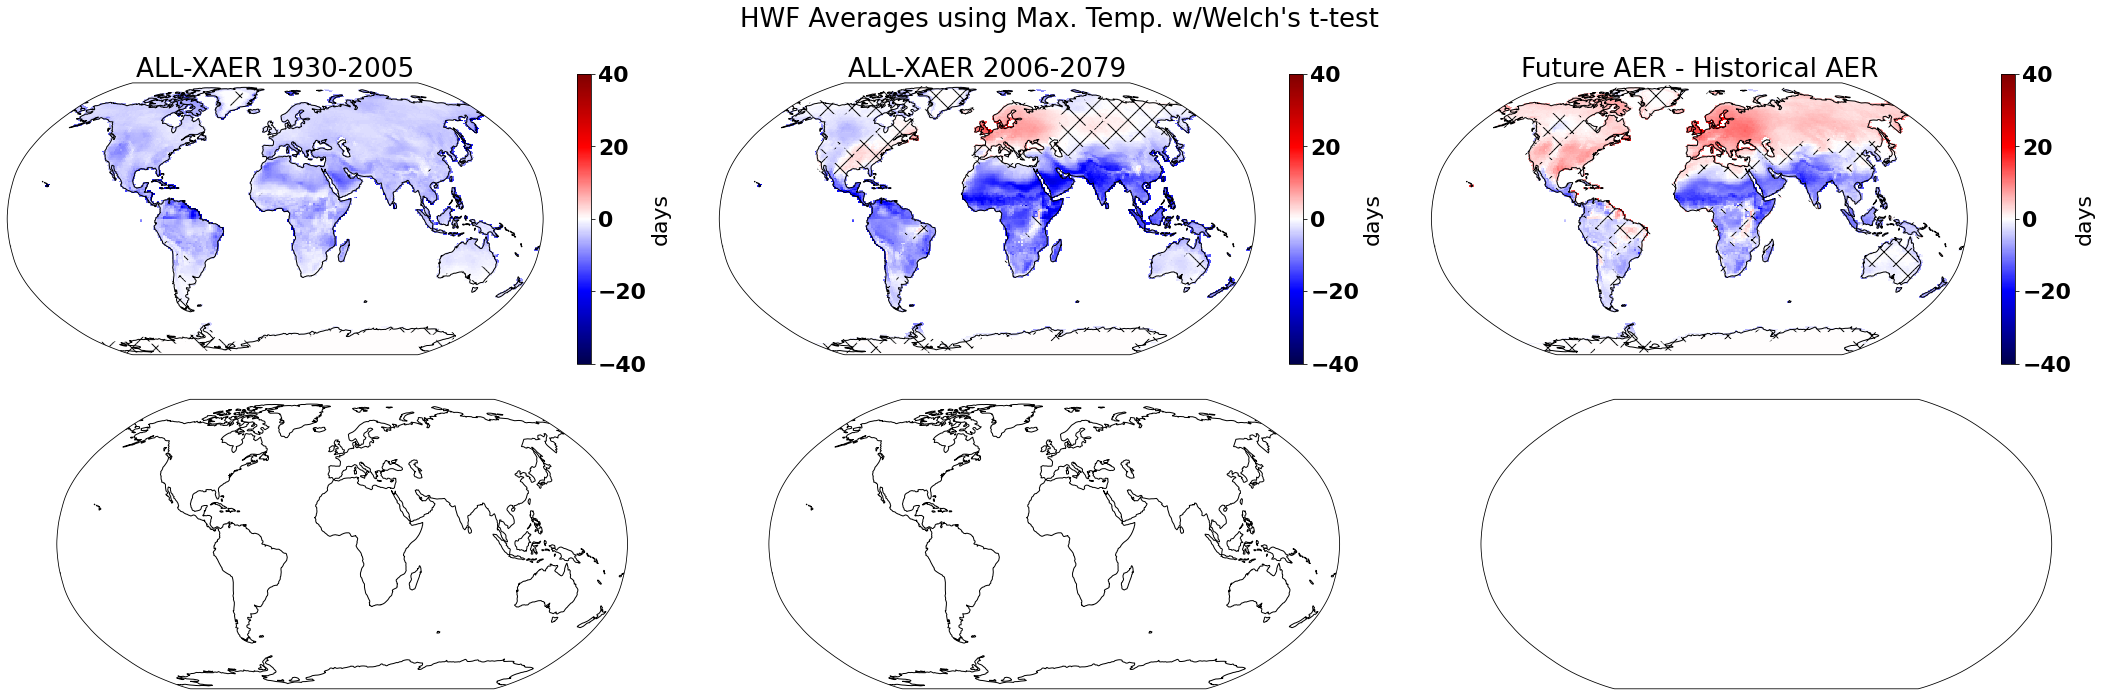

In [137]:
from paths import heat_out_trefht_tmin_members_1920_1950_CONTROL as tmin, heat_out_trefht_tmax_members_1920_1950_CONTROL as tmax, land_mask
import xarray
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import colors
from matplotlib import rc
import matplotlib.patches as mpatches
from analysis import t_test_mask
import numpy as np
from scipy.stats import ttest_ind


def sig_mask(all_ds, xaer_ds):
    
    def welch_t_test(all_pt, xaer_pt, lat, lon):
        # Confirmed that Sarah's modified t test is just a welches t test using my own code
        t_val, p_val = ttest_ind(all_pt, xaer_pt, equal_var=False)
        return ((lat, lon), p_val)
        
    #print("Converting to numpy array...")
    # (member, time, lat, lon)
    all_array = all_ds.values
    xaer_array = xaer_ds.values
    #print("Done.")
    
    results = []
    #print(f"Preforming test, modified={modified}")
    for lati, lat in enumerate(all_ds.lat.values):
        for loni, lon in enumerate(all_ds.lon.values):
            all_pt = all_array[0:all_ds["member"].size, 0:all_ds["time"].size, lati, loni].flatten()
            xaer_pt = xaer_array[0:xaer_ds["member"].size, 0:xaer_ds["time"].size, lati, loni].flatten()
            results.append(welch_t_test(all_pt, xaer_pt, lat, lon))
    
    if len(results) == all_min.lat.size*all_min.lon.size:
        #print("Shapes match, converting back to xarray...")
        pass
    else:
        raise RuntimeError(f'The mask size does not match the original dataset size: {len(mask)} != {all_min.lat.size*all_min.lon.size}')
    
    # Recycle ALL array
    return_array = (all_ds.mean(dim="member").mean(dim="time").load() * 0).rename("p-value")
    for index, ((lat, lon), value) in enumerate(results):
        return_array.loc[dict(lat=lat, lon=lon)] = value
    
    return return_array

exp_num = "3136"

vmin = -40
vmax = 40
cmap = "seismic"
var = "HWF"

sigmas = 2
modified = False

all_min, xghg_min, xaer_min = tmax()
land_m = xarray.open_dataset(land_mask())["__xarray_dataarray_variable__"]
all_min = xarray.open_mfdataset([path for path in all_min if exp_num in path], concat_dim="member", combine="nested")[f"{var}_tx90"].dt.days.sel(time=slice(1920,2079))
xaer_min = xarray.open_mfdataset([path for path in xaer_min if exp_num in path], concat_dim="member", combine="nested")[f"{var}_tx90"].dt.days.sel(time=slice(1920,2079))
ds_min = (all_min.mean(dim="member") - xaer_min.mean(dim="member")).where(land_m > 0)
ds_min = ds_min.assign_coords(lon=(((ds_min.lon + 180) % 360) - 180)).sortby('lon')

rc('font', **{'family': 'normal', 'weight': 'bold', 'size': 22})
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(30, 10), facecolor='w', subplot_kw={'projection': ccrs.Robinson()})
f.suptitle(f"{var} Averages using Max. Temp. w/Welch's t-test ", fontsize=26)

def region_plotting(map_ax, ds, dummy):
    """
    Adds pink boxes to each map
    
    """
    edge_s = 2
    edge_c = "#F70FD8"
    edge_ls = "--"
    
    map_ax.add_patch(mpatches.Rectangle(xy=[-20, 35], width=80, height=30, fill=False, edgecolor=edge_c, linestyle=edge_ls, linewidth=edge_s, transform=ccrs.PlateCarree()))
    europe = ds.where(ds.lat>35).where(ds.lat<65).where(ds.lon>-20).where(ds.lon<60).mean(dim="lat").mean(dim="lon").load()

    map_ax.add_patch(mpatches.Rectangle(xy=[-100, 25], width=40, height=30, fill=False, edgecolor=edge_c, linestyle=edge_ls, linewidth=edge_s, transform=ccrs.PlateCarree()))
    e_na = ds.where(ds.lat>25).where(ds.lat<55).where(ds.lon>-100).where(ds.lon<-60).mean(dim="lat").mean(dim="lon").load()
    
    map_ax.add_patch(mpatches.Rectangle(xy=[-90, 10], width=35, height=-35, fill=False, edgecolor=edge_c, linestyle=edge_ls, linewidth=edge_s, transform=ccrs.PlateCarree()))
    trop_s_amer = ds.where(ds.lat>-25).where(ds.lat<10).where(ds.lon>-90).where(ds.lon<-55).mean(dim="lat").mean(dim="lon").load()
    
    map_ax.add_patch(mpatches.Rectangle(xy=[-10, 15], width=55, height=-35, fill=False, edgecolor=edge_c, linestyle=edge_ls, linewidth=edge_s, transform=ccrs.PlateCarree()))
    africa = ds.where(ds.lat>-20).where(ds.lat<15).where(ds.lon>-10).where(ds.lon<45).mean(dim="lat").mean(dim="lon").load()
    
    map_ax.add_patch(mpatches.Rectangle(xy=[65, 5], width=55, height=35, fill=False, edgecolor=edge_c, linestyle=edge_ls, linewidth=edge_s, transform=ccrs.PlateCarree()))
    se_asia = ds.where(ds.lat>20).where(ds.lat<50).where(ds.lon>95).where(ds.lon<130).mean(dim="lat").mean(dim="lon").load()
    
    return (europe, e_na, trop_s_amer, africa, se_asia)
region_avgs = {}

hist = ds_min.sel(time=slice(1930, 2005)).mean(dim="time")
hist.plot(ax=ax1, transform=ccrs.PlateCarree(), vmax=vmax, vmin=vmin, cmap=cmap)
mask1 = sig_mask(all_min.sel(time=slice(1930, 2005)), xaer_min.sel(time=slice(1930, 2005)))
mask1 = mask1.where(mask1>0.05).where(land_m>0)
ax1.set_title("ALL-XAER 1930-2005")

fut = ds_min.sel(time=slice(2006, 2079)).mean(dim="time")
fut.plot(ax=ax2, transform=ccrs.PlateCarree(), vmax=vmax, vmin=vmin, cmap=cmap)
mask2 = sig_mask(all_min.sel(time=slice(2006, 2079)), xaer_min.sel(time=slice(2006, 2079)))
mask2 = mask2.where(mask2>0.05).where(land_m>0)
ax2.set_title("ALL-XAER 2006-2079")

(fut - hist).plot(ax=ax3, transform=ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax)
ax3.set_title("Future AER - Historical AER")
mask3 = sig_mask((all_min - xaer_min).sel(time=slice(2006, 2079)),  (all_min - xaer_min).sel(time=slice(1930, 2005)))
mask3 = mask3.where(mask3>0.05).where(land_m>0)

X, Y = np.meshgrid(mask1.lon, mask1.lat)
ax1.hexbin(X.reshape(-1), Y.reshape(-1), mask1.data.reshape(-1), hatch='x', alpha=0, transform=ccrs.PlateCarree())
ax2.hexbin(X.reshape(-1), Y.reshape(-1), mask2.data.reshape(-1), hatch='x', alpha=0, transform=ccrs.PlateCarree())
ax3.hexbin(X.reshape(-1), Y.reshape(-1), mask3.data.reshape(-1), hatch='x', alpha=0, transform=ccrs.PlateCarree())


ax1.coastlines()
ax2.coastlines()
ax3.coastlines()
ax4.coastlines()
ax5.coastlines()

f.tight_layout()

In [133]:
fut.std()

<xarray.DataArray 'days' ()>
array(6.75970214)

In [134]:
hist.std()

<xarray.DataArray 'days' ()>
array(4.73034159)